# *Imitation Learning with Behavior Cloning and DAGGER*
In this notebook, we will explore *imitation learning* using behavior cloning and DAGGER.

## *Objectives:*
1. *Understand Behavior Cloning* – Train an agent using supervised learning from expert demonstrations.
2. *Observe Covariate Shift* – Analyze the limitations of behavior cloning.
3. *Implement DAGGER* – Improve the agent using expert corrections iteratively.
4. *Visualize Performance* – Record videos of agent behavior.


In [ ]:
# sudo apt install g++ swig


In [ ]:
!pip install --upgrade pip setuptools wheel

In [ ]:

!apt-get update
!apt-get install -y swig cmake build-essential python3-dev
!pip install gymnasium[box2d]


Get:1 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Get:2 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,632 B]
Get:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  Packages [1,381 kB]
Hit:4 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:5 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]
Get:6 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Hit:7 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Get:8 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Hit:9 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:10 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Get:11 https://r2u.stat.illinois.edu/ubuntu jammy/main amd64 Packages [2,684 kB]
Get:12 https://r2u.stat.illinois.edu/ubuntu jammy/main all Packages [8,788 kB]
Get:13 http://archive.ubuntu.com/ubuntu jamm

In [ ]:
import gymnasium as gym
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from collections import deque
from torch.distributions import Categorical
import matplotlib.pyplot as plt
from tqdm import tqdm


## *Environment Setup*
In this section, we will set up the *LunarLander-v3* environment using the Gymnasium library. Our goal is to create a simulation environment where agents can receive observations and reward signals. We will initialize the environment, define observation and action spaces, and prepare it for both training and data generation.

In [ ]:
# Part 1: Environment Setup

# Initialize the Lunar Lander environment
env = gym.make("LunarLander-v3", render_mode="human")

In [ ]:
!pip install stable-baselines3[extra]


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 48.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 68.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 86.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 31.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 22.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 56.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 43.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 56.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 61.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 91.2 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvj

## Generating Expert Data (using an expert policy)
Here, we focus on generating expert data by executing an expert policy in the Lunar Lander environment. The expert policy will demonstrate optimal behavior, and we will collect trajectories (states, actions, rewards) as it interacts with the environment. This data will serve as a benchmark for training our imitation learning model.



In [ ]:
# Part 2: Generating Expert Data
from stable_baselines3 import PPO
from tqdm import tqdm


def generate_expert_data(env, expert_policy_path, num_episodes=10):
    """Generate expert data using a given policy."""

    expert_policy = PPO.load(expert_policy_path)

    data = []
    for _ in tqdm(range(num_episodes)):
        state, _ = env.reset()
        done = False
        while not done:
            action, _ = expert_policy.predict(state)
            data.append((state, action))
            state, _, done, _, _ = env.step(action)
    return data



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Collect the expert data
expert_data = generate_expert_data(env, expert_policy_path="/content/drive/MyDrive/Mir/ppo_lunarlander_v1 (1).zip")

/usr/local/lib/python3.11/dist-packages/stable_baselines3/common/save_util.py:165: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy internals and its use is discouraged, as NumPy internals can change without warning in any release. In practice, most real-world usage of numpy.core is to access functionality in the public NumPy API. If that is the case, use the public NumPy API. If not, you are using NumPy internals. If you would still like to access an internal attribute, use numpy._core.numeric._frombuffer.
  deserialized_object = cloudpickle.loads(base64_object)
/usr/local/lib/python3.11/dist-packages/stable_baselines3/common/save_util.py:167: UserWarning: Could not deserialize object clip_range. Consider using `custom_objects` argument to replace this object.
Exception: code() argument 13 must be str, not int
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/stable_baselines3/comm

## Prepare and Train using Behavioral Cloning
In this segment, we will prepare our data for training a machine learning model using Behavioral Cloning. This involves preprocessing the collected expert data and training a model to mimic the expert policy. The model will learn to map observations directly to actions, emulating the expert's decision-making process.

In [ ]:
# Prepare dataset
X_train = np.array([x[0] for x in expert_data])
y_train = np.array([x[1] for x in expert_data])


In [ ]:
# Part 3: Defining the Imitation Learning Model

class ImitationNetwork(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(ImitationNetwork, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, output_dim),
            nn.Softmax(dim=-1)
        )

    def forward(self, x):
        return self.network(x)

In [ ]:
# Instantiate the model
input_dim = X_train.shape[1]
output_dim = 4  # One for each action in LunarLander
model = ImitationNetwork(input_dim, output_dim).to('cuda')

In [ ]:
# Part 4: Training Behavior Cloning Model


In [ ]:

# Convert dataset to PyTorch tensors
X_train_tensor = torch.FloatTensor(X_train).to('cuda')
y_train_tensor = torch.LongTensor(y_train).to('cuda')


In [ ]:

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [ ]:

# Training loop
num_epochs = 1000
batch_size = 64

for epoch in range(num_epochs):
    # Shuffle data
    indices = np.random.permutation(len(X_train))
    for i in range(0, len(X_train), batch_size):
        batch_indices = indices[i:i + batch_size]
        X_batch = X_train_tensor[batch_indices]
        y_batch = y_train_tensor[batch_indices]

        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()

    if (epoch + 1) % 100 == 0:
        print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}")

Epoch [100/1000], Loss: 0.9903
Epoch [200/1000], Loss: 1.0016
Epoch [300/1000], Loss: 0.9451
Epoch [400/1000], Loss: 1.0490
Epoch [500/1000], Loss: 0.8692
Epoch [600/1000], Loss: 0.9126
Epoch [700/1000], Loss: 0.9521
Epoch [800/1000], Loss: 0.9673
Epoch [900/1000], Loss: 0.8687
Epoch [1000/1000], Loss: 1.0017


## Evaluating the Model
In this part, we will evaluate the performance of our trained model. Using a set of metrics, we will compare the behavior of the cloned model to the expert policy within the Lunar Lander environment. We aim to assess how well the model generalizes the expert’s actions under different scenarios.

In [ ]:
# Part 5: Evaluating the Model

def evaluate(env, model, num_episodes=10):
    rewards = []
    max_steps = 1000
    for _ in tqdm(range(num_episodes)):
        state, _ = env.reset()
        done = False
        total_reward = 0
        i=0
        while not done and i<max_steps:
            i+=1
            state_tensor = torch.FloatTensor(state).unsqueeze(0)
            with torch.no_grad():
                action_probs = model(state_tensor)
            action = torch.argmax(action_probs, dim=1).item()
            state, reward, done, _, _ = env.step(action)
            total_reward += reward
        rewards.append(total_reward)
        print(f'Total reward: {total_reward}')
    return rewards

In [ ]:

# Evaluate the trained model
rewards = evaluate(env, model.to('cpu'),num_episodes=1)
print(f"Average reward over {len(rewards)} episodes: {np.mean(rewards)}")

100%|██████████| 1/1 [00:01<00:00,  1.60s/it]

Total reward: -361.1913451003675
Average reward over 1 episodes: -361.1913451003675


## Video Playback
This section is dedicated to visualizing the trained model's performance through video playback. By capturing the agent's interaction with the environment, we can qualitatively assess how closely the model's actions align with the expert's behavior and evaluate its effectiveness in completing tasks.

In [ ]:
# Part 6: Video Playback

import imageio
from gymnasium.wrappers import RecordVideo

env_video = gym.make("LunarLander-v3", render_mode="rgb_array")
# Set up the video recording environment
video_env = RecordVideo(env_video, video_folder='videos/')

# Function to save video of the agent's performance
def make_video(env, model, num_episodes=1):
    for _ in range(num_episodes):
        state, _ = env.reset()
        done = False
        steps = 0
        while not done:
            steps +=1
            state_tensor = torch.FloatTensor(state).unsqueeze(0)
            with torch.no_grad():
                action_probs = model(state_tensor)
            action = torch.argmax(action_probs, dim=1).item()
            state, _, done, _, _ = env.step(action)
        print(f'Steps: {steps}')

    env.close()



/usr/local/lib/python3.11/dist-packages/moviepy/config_defaults.py:1: DeprecationWarning: invalid escape sequence '\P'
  """


In [ ]:

# Run the trained policy and create a video
make_video(video_env, model)

Steps: 89


In [ ]:
from IPython.display import Video, display

In [ ]:
ls -lh videos

total 0


In [ ]:
# Display the video in the notebook
video_path = './videos/rl-video-episode-0.mp4'  # Modify this path if necessary
display(Video(video_path, embed=True))

## DAgger: Implement and Run
Finally, we will implement and run the Dataset Aggregation (DAgger) algorithm. DAgger iteratively improves the imitation learning model by incorporating feedback from the expert policy during the training process. This section will detail how to modify the initial model using the expert’s guidance, iteratively refining its performance.

In [ ]:
from tqdm import tqdm
def dagger(env, expert_policy, model, num_iterations=5, num_episodes_per_iter=10,num_epochs=5):

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=1e-3)
    batch_size= 1024

    all_data = []
    losses = []

    for iteration in range(num_iterations):
        print(f"## Iteration: {iteration} ###########")
        # Step 1: Generate data from model
        print("Step 1: Generate data from model")
        new_data = []
        max_steps = 600
        total_returns = []
        for _ in tqdm(range(num_episodes_per_iter)):
            state, _ = env.reset()
            done = False
            i=0
            return_ = 0
            while not done and i<max_steps:
                i+=1
                state_tensor = torch.FloatTensor(state).unsqueeze(0).to('cuda')
                with torch.no_grad():
                    action_probs = model(state_tensor)
                action = torch.argmax(action_probs, dim=1).item()
                new_data.append((state, action))
                state, reward, done, _, _ = env.step(action)
                return_ += reward
            total_returns.append(return_)
        print(f"Avg. Return : {np.mean(total_returns)}")
        # Step 2: Aggregate new data with all previous data


        # Step 3: Label new data with expert policy
        print("Step 2: Label new data with expert policy")
        labeled_data = []
        for state, _ in new_data:
            expert_action, _ = expert_policy.predict(state)
            labeled_data.append((state, expert_action))


        print(f"Step 3: Aggregate new data with all previous data. Size: {len(all_data)}")
        all_data.extend(labeled_data)

        # Step 4: Retrain model with new combined dataset
        print("Step 4: Retrain model with new combined dataset")
        X_train_dagger = np.array([x[0] for x in all_data])
        y_train_dagger = np.array([x[1] for x in all_data])

        X_train_tensor_dagger = torch.FloatTensor(X_train_dagger).to('cuda')
        y_train_tensor_dagger = torch.LongTensor(y_train_dagger).to('cuda')

        # Retrain model
        for epoch in tqdm(range(num_epochs)):
            indices = np.random.permutation(len(X_train_dagger))
            for i in range(0, len(X_train_dagger), batch_size):
                batch_indices = indices[i:i + batch_size]
                X_batch = X_train_tensor_dagger[batch_indices]
                y_batch = y_train_tensor_dagger[batch_indices]

                optimizer.zero_grad()
                outputs = model(X_batch)
                loss = criterion(outputs, y_batch)
                loss.backward()
                optimizer.step()

                losses.append(loss.item())

            if (epoch + 1) % 100 == 0:
                print(f"DAgger Epoch [{epoch + 1}/{num_epochs}], Loss: {np.mean(losses):.4f}")
                losses = []

    return model

In [ ]:
# Implement and run the DAgger algorithm
expert_policy = PPO.load("ppo_lunarlander_v1")
model = ImitationNetwork(input_dim, output_dim).to('cuda')

dagger_model = dagger(env, expert_policy, model,
                     num_iterations=5,
                      num_episodes_per_iter=5,
                      num_epochs=5000)

## Iteration: 0 ###########
Step 1: Generate data from model


100%|██████████| 5/5 [00:08<00:00,  1.66s/it]


Avg. Return : -373.96903667350034
Step 2: Label new data with expert policy
Step 3: Aggregate new data with all previous data. Size: 0
Step 4: Retrain model with new combined dataset


  2%|▏         | 86/5000 [00:00<00:05, 851.09it/s]

DAgger Epoch [100/5000], Loss: 1.0281


  5%|▌         | 254/5000 [00:00<00:05, 799.41it/s]

DAgger Epoch [200/5000], Loss: 0.8857
DAgger Epoch [300/5000], Loss: 0.8809


 12%|█▏        | 584/5000 [00:00<00:06, 650.48it/s]

DAgger Epoch [400/5000], Loss: 0.8789
DAgger Epoch [500/5000], Loss: 0.8781


 13%|█▎        | 671/5000 [00:01<00:06, 706.29it/s]

DAgger Epoch [600/5000], Loss: 0.8778
DAgger Epoch [700/5000], Loss: 0.8775


 18%|█▊        | 904/5000 [00:01<00:06, 601.43it/s]

DAgger Epoch [800/5000], Loss: 0.8744
DAgger Epoch [900/5000], Loss: 0.8716


 21%|██▏       | 1074/5000 [00:01<00:05, 693.14it/s]

DAgger Epoch [1000/5000], Loss: 0.8698
DAgger Epoch [1100/5000], Loss: 0.8685


 26%|██▌       | 1303/5000 [00:02<00:06, 589.37it/s]

DAgger Epoch [1200/5000], Loss: 0.8677
DAgger Epoch [1300/5000], Loss: 0.8672


 30%|██▉       | 1478/5000 [00:02<00:04, 707.42it/s]

DAgger Epoch [1400/5000], Loss: 0.8668
DAgger Epoch [1500/5000], Loss: 0.8666


 34%|███▎      | 1680/5000 [00:02<00:06, 503.53it/s]

DAgger Epoch [1600/5000], Loss: 0.8665


 36%|███▋      | 1821/5000 [00:03<00:05, 589.81it/s]

DAgger Epoch [1700/5000], Loss: 0.8664
DAgger Epoch [1800/5000], Loss: 0.8663


 41%|████      | 2036/5000 [00:03<00:04, 612.00it/s]

DAgger Epoch [1900/5000], Loss: 0.8663
DAgger Epoch [2000/5000], Loss: 0.8662


 44%|████▍     | 2215/5000 [00:03<00:03, 739.71it/s]

DAgger Epoch [2100/5000], Loss: 0.8662
DAgger Epoch [2200/5000], Loss: 0.8662


 48%|████▊     | 2385/5000 [00:03<00:03, 791.02it/s]

DAgger Epoch [2300/5000], Loss: 0.8662
DAgger Epoch [2400/5000], Loss: 0.8661


 52%|█████▏    | 2605/5000 [00:04<00:03, 602.80it/s]

DAgger Epoch [2500/5000], Loss: 0.8661
DAgger Epoch [2600/5000], Loss: 0.8661


 55%|█████▍    | 2741/5000 [00:04<00:03, 586.96it/s]

DAgger Epoch [2700/5000], Loss: 0.8661
DAgger Epoch [2800/5000], Loss: 0.8661


 58%|█████▊    | 2919/5000 [00:04<00:03, 550.87it/s]

DAgger Epoch [2900/5000], Loss: 0.8661


 62%|██████▏   | 3100/5000 [00:05<00:03, 516.22it/s]

DAgger Epoch [3000/5000], Loss: 0.8661
DAgger Epoch [3100/5000], Loss: 0.8661


 66%|██████▌   | 3291/5000 [00:05<00:02, 715.89it/s]

DAgger Epoch [3200/5000], Loss: 0.8661
DAgger Epoch [3300/5000], Loss: 0.8661


 70%|██████▉   | 3488/5000 [00:06<00:03, 471.54it/s]

DAgger Epoch [3400/5000], Loss: 0.8661
DAgger Epoch [3500/5000], Loss: 0.8661


 75%|███████▌  | 3751/5000 [00:06<00:01, 700.42it/s]

DAgger Epoch [3600/5000], Loss: 0.8661
DAgger Epoch [3700/5000], Loss: 0.8661


 77%|███████▋  | 3827/5000 [00:06<00:01, 650.21it/s]

DAgger Epoch [3800/5000], Loss: 0.8661


 79%|███████▉  | 3956/5000 [00:06<00:02, 515.87it/s]

DAgger Epoch [3900/5000], Loss: 0.8661


 81%|████████▏ | 4067/5000 [00:07<00:01, 506.43it/s]

DAgger Epoch [4000/5000], Loss: 0.8661
DAgger Epoch [4100/5000], Loss: 0.8661


 87%|████████▋ | 4335/5000 [00:07<00:00, 737.47it/s]

DAgger Epoch [4200/5000], Loss: 0.8661
DAgger Epoch [4300/5000], Loss: 0.8661


 90%|████████▉ | 4478/5000 [00:07<00:00, 587.67it/s]

DAgger Epoch [4400/5000], Loss: 0.8661
DAgger Epoch [4500/5000], Loss: 0.8661


 95%|█████████▌| 4760/5000 [00:07<00:00, 792.11it/s]

DAgger Epoch [4600/5000], Loss: 0.8661
DAgger Epoch [4700/5000], Loss: 0.8661


 97%|█████████▋| 4843/5000 [00:08<00:00, 680.58it/s]

DAgger Epoch [4800/5000], Loss: 0.8661


100%|██████████| 5000/5000 [00:08<00:00, 596.18it/s]


DAgger Epoch [4900/5000], Loss: 0.8661
DAgger Epoch [5000/5000], Loss: 0.8661
## Iteration: 1 ###########
Step 1: Generate data from model


100%|██████████| 5/5 [00:07<00:00,  1.58s/it]


Avg. Return : -143.86523911487606
Step 2: Label new data with expert policy
Step 3: Aggregate new data with all previous data. Size: 335
Step 4: Retrain model with new combined dataset


  3%|▎         | 152/5000 [00:00<00:09, 500.49it/s]

DAgger Epoch [100/5000], Loss: 1.1163


  5%|▍         | 249/5000 [00:00<00:10, 446.94it/s]

DAgger Epoch [200/5000], Loss: 1.1032
DAgger Epoch [300/5000], Loss: 1.0996


 10%|█         | 518/5000 [00:00<00:05, 752.63it/s]

DAgger Epoch [400/5000], Loss: 0.9939
DAgger Epoch [500/5000], Loss: 0.8501


 14%|█▍        | 695/5000 [00:01<00:06, 694.23it/s]

DAgger Epoch [600/5000], Loss: 0.8455
DAgger Epoch [700/5000], Loss: 0.8435


 17%|█▋        | 848/5000 [00:01<00:07, 590.83it/s]

DAgger Epoch [800/5000], Loss: 0.8419


 20%|█▉        | 997/5000 [00:01<00:06, 625.84it/s]

DAgger Epoch [900/5000], Loss: 0.8385
DAgger Epoch [1000/5000], Loss: 0.8378


 24%|██▎       | 1176/5000 [00:02<00:07, 516.26it/s]

DAgger Epoch [1100/5000], Loss: 0.8374


 25%|██▍       | 1230/5000 [00:02<00:08, 442.07it/s]

DAgger Epoch [1200/5000], Loss: 0.8370


 27%|██▋       | 1343/5000 [00:02<00:07, 480.88it/s]

DAgger Epoch [1300/5000], Loss: 0.8366
DAgger Epoch [1400/5000], Loss: 0.8363


 33%|███▎      | 1664/5000 [00:02<00:04, 674.86it/s]

DAgger Epoch [1500/5000], Loss: 0.8360
DAgger Epoch [1600/5000], Loss: 0.8357


 36%|███▌      | 1804/5000 [00:03<00:05, 627.74it/s]

DAgger Epoch [1700/5000], Loss: 0.8355
DAgger Epoch [1800/5000], Loss: 0.8353


 42%|████▏     | 2087/5000 [00:03<00:03, 820.08it/s]

DAgger Epoch [1900/5000], Loss: 0.8351
DAgger Epoch [2000/5000], Loss: 0.8350


 43%|████▎     | 2171/5000 [00:03<00:03, 708.79it/s]

DAgger Epoch [2100/5000], Loss: 0.8348
DAgger Epoch [2200/5000], Loss: 0.8347


 49%|████▉     | 2440/5000 [00:03<00:03, 830.89it/s]

DAgger Epoch [2300/5000], Loss: 0.8346
DAgger Epoch [2400/5000], Loss: 0.8345


 51%|█████     | 2532/5000 [00:04<00:02, 855.36it/s]

DAgger Epoch [2500/5000], Loss: 0.8326
DAgger Epoch [2600/5000], Loss: 0.8206


 57%|█████▋    | 2872/5000 [00:04<00:02, 754.59it/s]

DAgger Epoch [2700/5000], Loss: 0.8193
DAgger Epoch [2800/5000], Loss: 0.8191


 61%|██████    | 3058/5000 [00:04<00:02, 835.98it/s]

DAgger Epoch [2900/5000], Loss: 0.8190
DAgger Epoch [3000/5000], Loss: 0.8190


 63%|██████▎   | 3151/5000 [00:04<00:02, 861.53it/s]

DAgger Epoch [3100/5000], Loss: 0.8189


 65%|██████▍   | 3239/5000 [00:05<00:03, 584.16it/s]

DAgger Epoch [3200/5000], Loss: 0.8189
DAgger Epoch [3300/5000], Loss: 0.8188


 70%|███████   | 3518/5000 [00:05<00:01, 772.37it/s]

DAgger Epoch [3400/5000], Loss: 0.8188
DAgger Epoch [3500/5000], Loss: 0.8188


 74%|███████▎  | 3677/5000 [00:05<00:02, 534.24it/s]

DAgger Epoch [3600/5000], Loss: 0.8187


 75%|███████▍  | 3739/5000 [00:06<00:02, 445.86it/s]

DAgger Epoch [3700/5000], Loss: 0.8187


 77%|███████▋  | 3845/5000 [00:06<00:02, 467.50it/s]

DAgger Epoch [3800/5000], Loss: 0.8187
DAgger Epoch [3900/5000], Loss: 0.8187


 82%|████████▏ | 4116/5000 [00:06<00:01, 554.01it/s]

DAgger Epoch [4000/5000], Loss: 0.8187
DAgger Epoch [4100/5000], Loss: 0.8186


 87%|████████▋ | 4363/5000 [00:07<00:00, 730.57it/s]

DAgger Epoch [4200/5000], Loss: 0.8186
DAgger Epoch [4300/5000], Loss: 0.8186


 89%|████████▉ | 4454/5000 [00:07<00:00, 780.34it/s]

DAgger Epoch [4400/5000], Loss: 0.8186
DAgger Epoch [4500/5000], Loss: 0.8186


 94%|█████████▍| 4689/5000 [00:07<00:00, 592.24it/s]

DAgger Epoch [4600/5000], Loss: 0.8186
DAgger Epoch [4700/5000], Loss: 0.8186


 99%|█████████▉| 4974/5000 [00:07<00:00, 798.44it/s]

DAgger Epoch [4800/5000], Loss: 0.8186
DAgger Epoch [4900/5000], Loss: 0.8186


100%|██████████| 5000/5000 [00:07<00:00, 628.98it/s]


DAgger Epoch [5000/5000], Loss: 0.8186
## Iteration: 2 ###########
Step 1: Generate data from model


100%|██████████| 5/5 [00:23<00:00,  4.69s/it]


Avg. Return : -76.42320752301758
Step 2: Label new data with expert policy
Step 3: Aggregate new data with all previous data. Size: 654
Step 4: Retrain model with new combined dataset


  3%|▎         | 130/5000 [00:00<00:18, 256.64it/s]

DAgger Epoch [100/5000], Loss: 0.9473


  6%|▌         | 278/5000 [00:00<00:13, 338.05it/s]

DAgger Epoch [200/5000], Loss: 0.9282


  7%|▋         | 350/5000 [00:01<00:15, 309.98it/s]

DAgger Epoch [300/5000], Loss: 0.9265


  9%|▉         | 440/5000 [00:01<00:17, 263.23it/s]

DAgger Epoch [400/5000], Loss: 0.9247


 12%|█▏        | 576/5000 [00:01<00:11, 371.01it/s]

DAgger Epoch [500/5000], Loss: 0.9193


 12%|█▏        | 615/5000 [00:02<00:17, 254.30it/s]

DAgger Epoch [600/5000], Loss: 0.9119


 16%|█▌        | 790/5000 [00:02<00:11, 355.65it/s]

DAgger Epoch [700/5000], Loss: 0.9093


 17%|█▋        | 838/5000 [00:02<00:10, 385.65it/s]

DAgger Epoch [800/5000], Loss: 0.9078


 19%|█▉        | 970/5000 [00:03<00:10, 385.90it/s]

DAgger Epoch [900/5000], Loss: 0.9046


 21%|██        | 1062/5000 [00:03<00:09, 419.48it/s]

DAgger Epoch [1000/5000], Loss: 0.8969


 23%|██▎       | 1144/5000 [00:03<00:12, 299.79it/s]

DAgger Epoch [1100/5000], Loss: 0.8961


 25%|██▍       | 1239/5000 [00:04<00:15, 246.75it/s]

DAgger Epoch [1200/5000], Loss: 0.8944


 27%|██▋       | 1336/5000 [00:04<00:14, 255.25it/s]

DAgger Epoch [1300/5000], Loss: 0.8938


 28%|██▊       | 1419/5000 [00:04<00:16, 223.41it/s]

DAgger Epoch [1400/5000], Loss: 0.8936


 31%|███       | 1555/5000 [00:05<00:10, 319.33it/s]

DAgger Epoch [1500/5000], Loss: 0.8932


 33%|███▎      | 1633/5000 [00:05<00:11, 290.86it/s]

DAgger Epoch [1600/5000], Loss: 0.8926


 35%|███▌      | 1754/5000 [00:05<00:10, 320.52it/s]

DAgger Epoch [1700/5000], Loss: 0.8920


 37%|███▋      | 1840/5000 [00:06<00:09, 341.54it/s]

DAgger Epoch [1800/5000], Loss: 0.8924


 39%|███▉      | 1958/5000 [00:06<00:10, 297.98it/s]

DAgger Epoch [1900/5000], Loss: 0.8913


 41%|████      | 2052/5000 [00:06<00:07, 370.72it/s]

DAgger Epoch [2000/5000], Loss: 0.8912


 43%|████▎     | 2146/5000 [00:07<00:06, 415.28it/s]

DAgger Epoch [2100/5000], Loss: 0.8906


 45%|████▍     | 2231/5000 [00:07<00:08, 339.64it/s]

DAgger Epoch [2200/5000], Loss: 0.8909


 47%|████▋     | 2348/5000 [00:07<00:07, 353.54it/s]

DAgger Epoch [2300/5000], Loss: 0.8903


 49%|████▊     | 2431/5000 [00:07<00:07, 329.97it/s]

DAgger Epoch [2400/5000], Loss: 0.8901


 51%|█████     | 2555/5000 [00:08<00:07, 310.00it/s]

DAgger Epoch [2500/5000], Loss: 0.8901


 53%|█████▎    | 2639/5000 [00:08<00:07, 327.51it/s]

DAgger Epoch [2600/5000], Loss: 0.8898


 55%|█████▌    | 2752/5000 [00:09<00:07, 283.83it/s]

DAgger Epoch [2700/5000], Loss: 0.8897


 57%|█████▋    | 2848/5000 [00:09<00:05, 365.07it/s]

DAgger Epoch [2800/5000], Loss: 0.8896


 58%|█████▊    | 2895/5000 [00:09<00:05, 392.52it/s]

DAgger Epoch [2900/5000], Loss: 0.8895


 61%|██████▏   | 3069/5000 [00:10<00:05, 356.07it/s]

DAgger Epoch [3000/5000], Loss: 0.8885


 62%|██████▏   | 3117/5000 [00:10<00:04, 385.85it/s]

DAgger Epoch [3100/5000], Loss: 0.8864


 66%|██████▌   | 3291/5000 [00:10<00:04, 356.81it/s]

DAgger Epoch [3200/5000], Loss: 0.8867


 68%|██████▊   | 3387/5000 [00:10<00:03, 409.41it/s]

DAgger Epoch [3300/5000], Loss: 0.8861


 69%|██████▊   | 3434/5000 [00:11<00:03, 425.32it/s]

DAgger Epoch [3400/5000], Loss: 0.8863


 71%|███████▏  | 3566/5000 [00:11<00:04, 340.32it/s]

DAgger Epoch [3500/5000], Loss: 0.8863


 73%|███████▎  | 3662/5000 [00:11<00:03, 398.87it/s]

DAgger Epoch [3600/5000], Loss: 0.8862


 74%|███████▍  | 3705/5000 [00:11<00:03, 325.93it/s]

DAgger Epoch [3700/5000], Loss: 0.8860


 77%|███████▋  | 3868/5000 [00:12<00:03, 323.29it/s]

DAgger Epoch [3800/5000], Loss: 0.8860


 78%|███████▊  | 3906/5000 [00:12<00:04, 236.49it/s]

DAgger Epoch [3900/5000], Loss: 0.8854


 81%|████████  | 4058/5000 [00:13<00:02, 329.76it/s]

DAgger Epoch [4000/5000], Loss: 0.8851


 83%|████████▎ | 4143/5000 [00:13<00:02, 332.45it/s]

DAgger Epoch [4100/5000], Loss: 0.8845


 85%|████████▌ | 4255/5000 [00:13<00:02, 297.87it/s]

DAgger Epoch [4200/5000], Loss: 0.8836


 87%|████████▋ | 4349/5000 [00:14<00:01, 372.49it/s]

DAgger Epoch [4300/5000], Loss: 0.8834


 89%|████████▉ | 4470/5000 [00:14<00:01, 306.26it/s]

DAgger Epoch [4400/5000], Loss: 0.8832


 91%|█████████▏| 4564/5000 [00:14<00:01, 376.47it/s]

DAgger Epoch [4500/5000], Loss: 0.8830


 93%|█████████▎| 4658/5000 [00:15<00:00, 419.50it/s]

DAgger Epoch [4600/5000], Loss: 0.8831


 95%|█████████▌| 4750/5000 [00:15<00:00, 332.42it/s]

DAgger Epoch [4700/5000], Loss: 0.8827


 98%|█████████▊| 4891/5000 [00:15<00:00, 409.18it/s]

DAgger Epoch [4800/5000], Loss: 0.8828
DAgger Epoch [4900/5000], Loss: 0.8829


100%|██████████| 5000/5000 [00:16<00:00, 307.50it/s]


DAgger Epoch [5000/5000], Loss: 0.8831
## Iteration: 3 ###########
Step 1: Generate data from model


100%|██████████| 5/5 [00:34<00:00,  6.91s/it]


Avg. Return : 141.7530917556116
Step 2: Label new data with expert policy
Step 3: Aggregate new data with all previous data. Size: 1643
Step 4: Retrain model with new combined dataset


  2%|▏         | 102/5000 [00:00<00:27, 179.87it/s]

DAgger Epoch [100/5000], Loss: 0.9491


  5%|▍         | 243/5000 [00:01<00:24, 190.53it/s]

DAgger Epoch [200/5000], Loss: 0.9145


  7%|▋         | 333/5000 [00:02<00:25, 186.14it/s]

DAgger Epoch [300/5000], Loss: 0.8944


  8%|▊         | 424/5000 [00:02<00:29, 154.72it/s]

DAgger Epoch [400/5000], Loss: 0.8870


 10%|█         | 513/5000 [00:03<00:28, 159.86it/s]

DAgger Epoch [500/5000], Loss: 0.8839


 12%|█▏        | 621/5000 [00:03<00:23, 186.22it/s]

DAgger Epoch [600/5000], Loss: 0.8760


 15%|█▍        | 726/5000 [00:04<00:24, 172.58it/s]

DAgger Epoch [700/5000], Loss: 0.8738


 17%|█▋        | 828/5000 [00:05<00:25, 164.01it/s]

DAgger Epoch [800/5000], Loss: 0.8731


 18%|█▊        | 923/5000 [00:06<00:27, 148.58it/s]

DAgger Epoch [900/5000], Loss: 0.8735


 20%|██        | 1015/5000 [00:06<00:26, 150.47it/s]

DAgger Epoch [1000/5000], Loss: 0.8675


 23%|██▎       | 1131/5000 [00:07<00:21, 182.57it/s]

DAgger Epoch [1100/5000], Loss: 0.8642


 25%|██▍       | 1227/5000 [00:07<00:16, 222.96it/s]

DAgger Epoch [1200/5000], Loss: 0.8722


 26%|██▋       | 1317/5000 [00:08<00:24, 153.02it/s]

DAgger Epoch [1300/5000], Loss: 0.8618


 28%|██▊       | 1413/5000 [00:09<00:32, 111.49it/s]

DAgger Epoch [1400/5000], Loss: 0.8666


 30%|███       | 1514/5000 [00:09<00:23, 145.71it/s]

DAgger Epoch [1500/5000], Loss: 0.8580


 32%|███▏      | 1624/5000 [00:10<00:18, 181.13it/s]

DAgger Epoch [1600/5000], Loss: 0.8534


 34%|███▍      | 1725/5000 [00:11<00:18, 175.45it/s]

DAgger Epoch [1700/5000], Loss: 0.8526


 36%|███▋      | 1817/5000 [00:11<00:15, 210.32it/s]

DAgger Epoch [1800/5000], Loss: 0.8506


 38%|███▊      | 1922/5000 [00:12<00:19, 161.71it/s]

DAgger Epoch [1900/5000], Loss: 0.8523


 40%|████      | 2009/5000 [00:13<00:25, 119.53it/s]

DAgger Epoch [2000/5000], Loss: 0.8512


 42%|████▎     | 2125/5000 [00:14<00:20, 143.18it/s]

DAgger Epoch [2100/5000], Loss: 0.8489


 45%|████▍     | 2226/5000 [00:14<00:18, 148.09it/s]

DAgger Epoch [2200/5000], Loss: 0.8493


 47%|████▋     | 2330/5000 [00:15<00:13, 203.30it/s]

DAgger Epoch [2300/5000], Loss: 0.8503


 49%|████▊     | 2426/5000 [00:15<00:11, 228.89it/s]

DAgger Epoch [2400/5000], Loss: 0.8462


 50%|█████     | 2522/5000 [00:16<00:10, 230.09it/s]

DAgger Epoch [2500/5000], Loss: 0.8451


 52%|█████▏    | 2618/5000 [00:16<00:18, 126.13it/s]

DAgger Epoch [2600/5000], Loss: 0.8495


 54%|█████▍    | 2723/5000 [00:17<00:13, 164.94it/s]

DAgger Epoch [2700/5000], Loss: 0.8476


 56%|█████▋    | 2817/5000 [00:18<00:17, 121.64it/s]

DAgger Epoch [2800/5000], Loss: 0.8460


 58%|█████▊    | 2925/5000 [00:19<00:15, 133.59it/s]

DAgger Epoch [2900/5000], Loss: 0.8420


 61%|██████    | 3045/5000 [00:19<00:08, 217.42it/s]

DAgger Epoch [3000/5000], Loss: 0.8469


 62%|██████▏   | 3116/5000 [00:20<00:12, 151.68it/s]

DAgger Epoch [3100/5000], Loss: 0.8453


 64%|██████▍   | 3220/5000 [00:20<00:09, 189.78it/s]

DAgger Epoch [3200/5000], Loss: 0.8429


 66%|██████▋   | 3320/5000 [00:21<00:09, 182.45it/s]

DAgger Epoch [3300/5000], Loss: 0.8434


 68%|██████▊   | 3423/5000 [00:22<00:09, 159.65it/s]

DAgger Epoch [3400/5000], Loss: 0.8428


 70%|███████   | 3517/5000 [00:23<00:12, 120.33it/s]

DAgger Epoch [3500/5000], Loss: 0.8510


 73%|███████▎  | 3647/5000 [00:23<00:06, 203.40it/s]

DAgger Epoch [3600/5000], Loss: 0.8451


 75%|███████▍  | 3741/5000 [00:24<00:05, 224.00it/s]

DAgger Epoch [3700/5000], Loss: 0.8435


 77%|███████▋  | 3828/5000 [00:24<00:06, 177.70it/s]

DAgger Epoch [3800/5000], Loss: 0.8431


 78%|███████▊  | 3916/5000 [00:25<00:06, 165.28it/s]

DAgger Epoch [3900/5000], Loss: 0.8447


 80%|████████  | 4008/5000 [00:25<00:07, 129.49it/s]

DAgger Epoch [4000/5000], Loss: 0.8436


 82%|████████▏ | 4109/5000 [00:26<00:04, 193.98it/s]

DAgger Epoch [4100/5000], Loss: 0.8431


 85%|████████▍ | 4231/5000 [00:27<00:04, 164.54it/s]

DAgger Epoch [4200/5000], Loss: 0.8409


 87%|████████▋ | 4345/5000 [00:27<00:03, 216.37it/s]

DAgger Epoch [4300/5000], Loss: 0.8454


 88%|████████▊ | 4413/5000 [00:28<00:03, 151.69it/s]

DAgger Epoch [4400/5000], Loss: 0.8457


 90%|█████████ | 4524/5000 [00:28<00:02, 172.15it/s]

DAgger Epoch [4500/5000], Loss: 0.8429


 92%|█████████▏| 4607/5000 [00:29<00:02, 133.48it/s]

DAgger Epoch [4600/5000], Loss: 0.8438


 94%|█████████▍| 4718/5000 [00:30<00:01, 182.94it/s]

DAgger Epoch [4700/5000], Loss: 0.8390


 97%|█████████▋| 4846/5000 [00:31<00:00, 208.61it/s]

DAgger Epoch [4800/5000], Loss: 0.8382


 99%|█████████▊| 4937/5000 [00:31<00:00, 210.15it/s]

DAgger Epoch [4900/5000], Loss: 0.8424


100%|██████████| 5000/5000 [00:32<00:00, 155.35it/s]


DAgger Epoch [5000/5000], Loss: 0.8391
## Iteration: 4 ###########
Step 1: Generate data from model


100%|██████████| 5/5 [00:31<00:00,  6.27s/it]


Avg. Return : 252.824949001133
Step 2: Label new data with expert policy
Step 3: Aggregate new data with all previous data. Size: 3099
Step 4: Retrain model with new combined dataset


  2%|▏         | 119/5000 [00:00<00:34, 140.84it/s]

DAgger Epoch [100/5000], Loss: 0.9002


  4%|▍         | 213/5000 [00:01<00:42, 113.48it/s]

DAgger Epoch [200/5000], Loss: 0.8919


  6%|▋         | 324/5000 [00:02<00:30, 155.02it/s]

DAgger Epoch [300/5000], Loss: 0.8904


  9%|▊         | 429/5000 [00:03<00:29, 153.30it/s]

DAgger Epoch [400/5000], Loss: 0.8904


 10%|█         | 512/5000 [00:04<00:35, 126.30it/s]

DAgger Epoch [500/5000], Loss: 0.8892


 12%|█▏        | 615/5000 [00:04<00:38, 114.34it/s]

DAgger Epoch [600/5000], Loss: 0.8887


 14%|█▍        | 716/5000 [00:05<00:33, 128.27it/s]

DAgger Epoch [700/5000], Loss: 0.8881


 16%|█▋        | 813/5000 [00:06<00:29, 144.28it/s]

DAgger Epoch [800/5000], Loss: 0.8871


 18%|█▊        | 923/5000 [00:07<00:38, 105.06it/s]

DAgger Epoch [900/5000], Loss: 0.8862


 20%|██        | 1017/5000 [00:08<00:36, 110.50it/s]

DAgger Epoch [1000/5000], Loss: 0.8852


 22%|██▏       | 1113/5000 [00:08<00:29, 131.98it/s]

DAgger Epoch [1100/5000], Loss: 0.8849


 24%|██▍       | 1217/5000 [00:09<00:27, 136.94it/s]

DAgger Epoch [1200/5000], Loss: 0.8843


 26%|██▋       | 1317/5000 [00:10<00:22, 163.25it/s]

DAgger Epoch [1300/5000], Loss: 0.8841


 28%|██▊       | 1409/5000 [00:10<00:22, 157.98it/s]

DAgger Epoch [1400/5000], Loss: 0.8841


 30%|███       | 1510/5000 [00:11<00:26, 130.36it/s]

DAgger Epoch [1500/5000], Loss: 0.8836


 32%|███▏      | 1613/5000 [00:12<00:33, 101.95it/s]

DAgger Epoch [1600/5000], Loss: 0.8832


 34%|███▍      | 1718/5000 [00:13<00:26, 121.88it/s]

DAgger Epoch [1700/5000], Loss: 0.8827


 37%|███▋      | 1828/5000 [00:14<00:20, 156.24it/s]

DAgger Epoch [1800/5000], Loss: 0.8828


 38%|███▊      | 1907/5000 [00:14<00:27, 112.75it/s]

DAgger Epoch [1900/5000], Loss: 0.8824


 40%|████      | 2016/5000 [00:16<00:32, 91.12it/s] 

DAgger Epoch [2000/5000], Loss: 0.8815


 42%|████▏     | 2110/5000 [00:17<00:35, 81.84it/s]

DAgger Epoch [2100/5000], Loss: 0.8817


 45%|████▍     | 2233/5000 [00:17<00:16, 170.06it/s]

DAgger Epoch [2200/5000], Loss: 0.8810


 47%|████▋     | 2332/5000 [00:18<00:14, 186.95it/s]

DAgger Epoch [2300/5000], Loss: 0.8812


 48%|████▊     | 2406/5000 [00:19<00:22, 113.39it/s]

DAgger Epoch [2400/5000], Loss: 0.8814


 51%|█████     | 2527/5000 [00:20<00:17, 138.87it/s]

DAgger Epoch [2500/5000], Loss: 0.8814


 52%|█████▏    | 2624/5000 [00:20<00:17, 135.18it/s]

DAgger Epoch [2600/5000], Loss: 0.8817


 54%|█████▍    | 2720/5000 [00:21<00:16, 139.45it/s]

DAgger Epoch [2700/5000], Loss: 0.8810


 57%|█████▋    | 2826/5000 [00:22<00:13, 158.35it/s]

DAgger Epoch [2800/5000], Loss: 0.8808


 58%|█████▊    | 2911/5000 [00:23<00:17, 120.66it/s]

DAgger Epoch [2900/5000], Loss: 0.8804


 60%|██████    | 3007/5000 [00:23<00:17, 115.49it/s]

DAgger Epoch [3000/5000], Loss: 0.8803


 62%|██████▏   | 3112/5000 [00:25<00:21, 89.56it/s] 

DAgger Epoch [3100/5000], Loss: 0.8803


 64%|██████▍   | 3224/5000 [00:26<00:13, 131.37it/s]

DAgger Epoch [3200/5000], Loss: 0.8802


 66%|██████▋   | 3313/5000 [00:26<00:12, 135.63it/s]

DAgger Epoch [3300/5000], Loss: 0.8801


 68%|██████▊   | 3409/5000 [00:27<00:11, 133.56it/s]

DAgger Epoch [3400/5000], Loss: 0.8797


 70%|██████▉   | 3496/5000 [00:27<00:09, 157.57it/s]

DAgger Epoch [3500/5000], Loss: 0.8800


 72%|███████▏  | 3602/5000 [00:28<00:13, 101.31it/s]

DAgger Epoch [3600/5000], Loss: 0.8796


 74%|███████▍  | 3714/5000 [00:29<00:13, 92.36it/s] 

DAgger Epoch [3700/5000], Loss: 0.8797


 76%|███████▌  | 3811/5000 [00:30<00:07, 163.17it/s]

DAgger Epoch [3800/5000], Loss: 0.8791


 78%|███████▊  | 3904/5000 [00:31<00:08, 136.30it/s]

DAgger Epoch [3900/5000], Loss: 0.8791


 80%|████████  | 4012/5000 [00:32<00:10, 97.76it/s] 

DAgger Epoch [4000/5000], Loss: 0.8791


 82%|████████▏ | 4116/5000 [00:33<00:09, 97.05it/s] 

DAgger Epoch [4100/5000], Loss: 0.8792


 85%|████████▍ | 4227/5000 [00:33<00:06, 123.84it/s]

DAgger Epoch [4200/5000], Loss: 0.8793


 86%|████████▋ | 4317/5000 [00:34<00:04, 144.73it/s]

DAgger Epoch [4300/5000], Loss: 0.8792


 88%|████████▊ | 4412/5000 [00:35<00:03, 166.75it/s]

DAgger Epoch [4400/5000], Loss: 0.8791


 90%|█████████ | 4513/5000 [00:35<00:03, 122.88it/s]

DAgger Epoch [4500/5000], Loss: 0.8789


 92%|█████████▏| 4606/5000 [00:36<00:03, 99.17it/s] 

DAgger Epoch [4600/5000], Loss: 0.8789


 94%|█████████▍| 4708/5000 [00:37<00:03, 96.98it/s] 

DAgger Epoch [4700/5000], Loss: 0.8790


 97%|█████████▋| 4829/5000 [00:38<00:01, 138.27it/s]

DAgger Epoch [4800/5000], Loss: 0.8804


 98%|█████████▊| 4905/5000 [00:39<00:00, 174.10it/s]

DAgger Epoch [4900/5000], Loss: 0.8801


100%|██████████| 5000/5000 [00:39<00:00, 125.06it/s]

DAgger Epoch [5000/5000], Loss: 0.8809


In [ ]:
rewards_dagger = evaluate(env, dagger_model.to('cpu'), num_episodes=10)
print(f"Average reward over {len(rewards_dagger)} DAgger episodes: {np.mean(rewards_dagger)}")

 10%|█         | 1/10 [00:03<00:33,  3.74s/it]

Total reward: 269.0916049408647


 20%|██        | 2/10 [00:07<00:30,  3.75s/it]

Total reward: 283.98334939401263


 30%|███       | 3/10 [00:11<00:28,  4.06s/it]

Total reward: 280.05081623451105


 30%|███       | 3/10 [00:14<00:33,  4.74s/it]


KeyboardInterrupt: 

In [ ]:
make_video(video_env, dagger_model)

Steps: 154


In [ ]:
# Display the video in the notebook
video_path = './videos/rl-video-episode-0.mp4'  # Modify this path if necessary
display(Video(video_path, embed=True))

## *📝 Student Experimentation*
Modify the following:
1. *Change the neural network architecture* (hidden layers, activation functions).
2. *Change the number of expert demonstrations* (increase/decrease).
3. *Modify the expert policy* to see its effect.
4. Implement *early stopping* to avoid overfitting.

*Expected Behavior:*
- With fewer demonstrations, the model may overfit.
- DAGGER should improve the model over iterations.
- A better network architecture might lead to better imitation.


____________________________________________


# 1. change the neural network architecture
### What I did
I created and trained two models:

  1. Original ImitationNetwork
    - Simple architecture with 2 hidden layers

     - Uses ReLU activation functions

  2. ModifiedImitationNetwork

    - Deeper network with 3 hidden layers

    - Uses a mix of Tanh, LeakyReLU, and ReLU

Then, I trained both models on the same expert dataset for 1000 epochs.
During training, I recorded the loss (how far the model's action was from the expert's) at each epoch.

Finally, I plotted both loss curves to compare how well they learned.



In [ ]:
class ModifiedImitationNetwork(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(ModifiedImitationNetwork, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.Tanh(),
            nn.Linear(256, 128),
            nn.LeakyReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, output_dim),
            nn.Softmax(dim=-1)
        )

    def forward(self, x):
        return self.network(x)


In [ ]:
original_model = ImitationNetwork(input_dim, output_dim).to('cuda')
modified_model = ModifiedImitationNetwork(input_dim, output_dim).to('cuda')

In [ ]:
def train_and_record_loss(model, X, y, epochs=1000, batch_size=64):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=1e-3)
    losses = []

    for epoch in range(epochs):
        indices = np.random.permutation(len(X))
        epoch_loss = 0
        for i in range(0, len(X), batch_size):
            batch_idx = indices[i:i+batch_size]
            X_batch = X[batch_idx]
            y_batch = y[batch_idx]

            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()
        losses.append(epoch_loss)
    return losses

In [ ]:
losses_original = train_and_record_loss(original_model, X_train_tensor, y_train_tensor)
losses_modified = train_and_record_loss(modified_model, X_train_tensor, y_train_tensor)


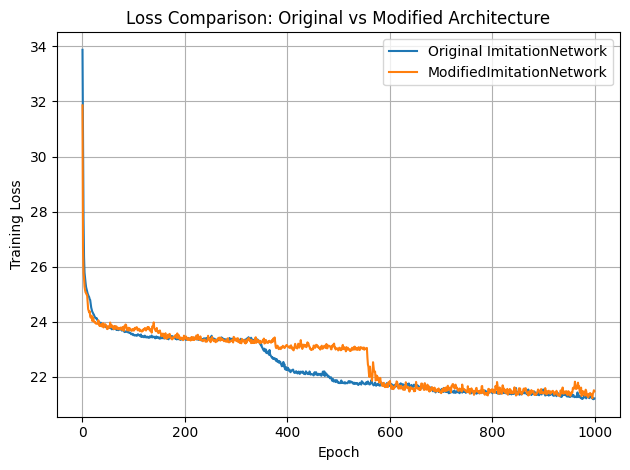

In [ ]:
import matplotlib.pyplot as plt

plt.plot(losses_original, label="Original ImitationNetwork")
plt.plot(losses_modified, label="ModifiedImitationNetwork")
plt.xlabel("Epoch")
plt.ylabel("Training Loss")
plt.title("Loss Comparison: Original vs Modified Architecture")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


🔹 Result Analysis
The graph shows the training loss of both models over 1000 epochs.

- Both models started with high loss and reduced it over time, which means both were learning.

- The original model (blue line) had slightly lower loss near the end.

- The modified model (orange line) was a bit more stable in the middle, but had slightly higher loss overall.

- The final performance of both models was similar, but the original model performed a little better in terms of training loss.

In [ ]:
from stable_baselines3 import PPO
expert_policy = PPO.load("/content/drive/MyDrive/Mir/ppo_lunarlander_v1 (1).zip")

/usr/local/lib/python3.11/dist-packages/stable_baselines3/common/save_util.py:165: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy internals and its use is discouraged, as NumPy internals can change without warning in any release. In practice, most real-world usage of numpy.core is to access functionality in the public NumPy API. If that is the case, use the public NumPy API. If not, you are using NumPy internals. If you would still like to access an internal attribute, use numpy._core.numeric._frombuffer.
  deserialized_object = cloudpickle.loads(base64_object)
/usr/local/lib/python3.11/dist-packages/stable_baselines3/common/save_util.py:167: UserWarning: Could not deserialize object clip_range. Consider using `custom_objects` argument to replace this object.
Exception: code() argument 13 must be str, not int
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/stable_baselines3/comm

In [ ]:
dagger_model = dagger(env, expert_policy, modified_model,
                     num_iterations=5,
                      num_episodes_per_iter=5,
                      num_epochs=5000)

## Iteration: 0 ###########
Step 1: Generate data from model


100%|██████████| 5/5 [00:51<00:00, 10.31s/it]


Avg. Return : 41.06332866667847
Step 2: Label new data with expert policy
Step 3: Aggregate new data with all previous data. Size: 0
Step 4: Retrain model with new combined dataset


  3%|▎         | 134/5000 [00:00<00:26, 184.05it/s]

DAgger Epoch [100/5000], Loss: 0.8735


  5%|▍         | 229/5000 [00:01<00:25, 184.13it/s]

DAgger Epoch [200/5000], Loss: 0.8345


  6%|▋         | 324/5000 [00:01<00:25, 184.74it/s]

DAgger Epoch [300/5000], Loss: 0.8291


  8%|▊         | 419/5000 [00:02<00:25, 182.94it/s]

DAgger Epoch [400/5000], Loss: 0.8234


 11%|█         | 533/5000 [00:02<00:24, 182.60it/s]

DAgger Epoch [500/5000], Loss: 0.8218


 13%|█▎        | 629/5000 [00:03<00:23, 186.35it/s]

DAgger Epoch [600/5000], Loss: 0.8156


 14%|█▍        | 724/5000 [00:03<00:23, 183.79it/s]

DAgger Epoch [700/5000], Loss: 0.8144


 16%|█▋        | 819/5000 [00:04<00:23, 177.40it/s]

DAgger Epoch [800/5000], Loss: 0.8136


 18%|█▊        | 918/5000 [00:05<00:27, 150.27it/s]

DAgger Epoch [900/5000], Loss: 0.8129


 20%|██        | 1015/5000 [00:05<00:26, 150.20it/s]

DAgger Epoch [1000/5000], Loss: 0.8124


 22%|██▏       | 1111/5000 [00:06<00:25, 151.70it/s]

DAgger Epoch [1100/5000], Loss: 0.8113


 24%|██▍       | 1213/5000 [00:07<00:29, 129.89it/s]

DAgger Epoch [1200/5000], Loss: 0.8106


 26%|██▋       | 1319/5000 [00:07<00:21, 170.96it/s]

DAgger Epoch [1300/5000], Loss: 0.8099


 29%|██▊       | 1433/5000 [00:08<00:19, 183.06it/s]

DAgger Epoch [1400/5000], Loss: 0.8099


 31%|███       | 1529/5000 [00:09<00:18, 183.81it/s]

DAgger Epoch [1500/5000], Loss: 0.8098


 32%|███▏      | 1624/5000 [00:09<00:18, 185.98it/s]

DAgger Epoch [1600/5000], Loss: 0.8093


 34%|███▍      | 1720/5000 [00:10<00:17, 184.10it/s]

DAgger Epoch [1700/5000], Loss: 0.8088


 37%|███▋      | 1834/5000 [00:10<00:17, 185.57it/s]

DAgger Epoch [1800/5000], Loss: 0.8087


 39%|███▊      | 1929/5000 [00:11<00:16, 184.09it/s]

DAgger Epoch [1900/5000], Loss: 0.8087


 40%|████      | 2025/5000 [00:11<00:15, 187.80it/s]

DAgger Epoch [2000/5000], Loss: 0.8096


 42%|████▏     | 2120/5000 [00:12<00:16, 178.13it/s]

DAgger Epoch [2100/5000], Loss: 0.8090


 45%|████▍     | 2234/5000 [00:12<00:15, 181.81it/s]

DAgger Epoch [2200/5000], Loss: 0.8074


 47%|████▋     | 2329/5000 [00:13<00:14, 181.54it/s]

DAgger Epoch [2300/5000], Loss: 0.8072


 48%|████▊     | 2424/5000 [00:13<00:14, 182.47it/s]

DAgger Epoch [2400/5000], Loss: 0.8071


 50%|█████     | 2518/5000 [00:14<00:14, 176.16it/s]

DAgger Epoch [2500/5000], Loss: 0.8072


 53%|█████▎    | 2633/5000 [00:15<00:13, 181.65it/s]

DAgger Epoch [2600/5000], Loss: 0.8072


 55%|█████▍    | 2729/5000 [00:15<00:12, 183.21it/s]

DAgger Epoch [2700/5000], Loss: 0.8094


 56%|█████▋    | 2824/5000 [00:16<00:11, 181.73it/s]

DAgger Epoch [2800/5000], Loss: 0.8080


 58%|█████▊    | 2919/5000 [00:16<00:11, 181.66it/s]

DAgger Epoch [2900/5000], Loss: 0.8075


 61%|██████    | 3032/5000 [00:17<00:11, 177.38it/s]

DAgger Epoch [3000/5000], Loss: 0.8076


 62%|██████▏   | 3119/5000 [00:17<00:11, 156.88it/s]

DAgger Epoch [3100/5000], Loss: 0.8071


 64%|██████▍   | 3217/5000 [00:18<00:11, 156.97it/s]

DAgger Epoch [3200/5000], Loss: 0.8087


 67%|██████▋   | 3329/5000 [00:19<00:10, 154.19it/s]

DAgger Epoch [3300/5000], Loss: 0.8069


 68%|██████▊   | 3421/5000 [00:19<00:11, 142.22it/s]

DAgger Epoch [3400/5000], Loss: 0.8064


 71%|███████   | 3533/5000 [00:20<00:08, 163.32it/s]

DAgger Epoch [3500/5000], Loss: 0.8070


 73%|███████▎  | 3630/5000 [00:21<00:07, 180.24it/s]

DAgger Epoch [3600/5000], Loss: 0.8092


 74%|███████▍  | 3725/5000 [00:21<00:06, 184.22it/s]

DAgger Epoch [3700/5000], Loss: 0.8068


 76%|███████▋  | 3820/5000 [00:22<00:06, 183.04it/s]

DAgger Epoch [3800/5000], Loss: 0.8057


 79%|███████▊  | 3934/5000 [00:22<00:05, 183.90it/s]

DAgger Epoch [3900/5000], Loss: 0.8059


 81%|████████  | 4029/5000 [00:23<00:05, 176.98it/s]

DAgger Epoch [4000/5000], Loss: 0.8060


 82%|████████▏ | 4123/5000 [00:23<00:04, 183.55it/s]

DAgger Epoch [4100/5000], Loss: 0.8090


 85%|████████▍ | 4237/5000 [00:24<00:04, 178.35it/s]

DAgger Epoch [4200/5000], Loss: 0.8068


 87%|████████▋ | 4332/5000 [00:25<00:03, 183.01it/s]

DAgger Epoch [4300/5000], Loss: 0.8066


 89%|████████▊ | 4426/5000 [00:25<00:03, 179.07it/s]

DAgger Epoch [4400/5000], Loss: 0.8061


 90%|█████████ | 4521/5000 [00:26<00:02, 182.55it/s]

DAgger Epoch [4500/5000], Loss: 0.8058


 93%|█████████▎| 4634/5000 [00:26<00:02, 182.55it/s]

DAgger Epoch [4600/5000], Loss: 0.8065


 95%|█████████▍| 4731/5000 [00:27<00:01, 181.85it/s]

DAgger Epoch [4700/5000], Loss: 0.8070


 97%|█████████▋| 4827/5000 [00:27<00:00, 185.85it/s]

DAgger Epoch [4800/5000], Loss: 0.8045


 98%|█████████▊| 4923/5000 [00:28<00:00, 184.26it/s]

DAgger Epoch [4900/5000], Loss: 0.8043


100%|██████████| 5000/5000 [00:28<00:00, 174.35it/s]


DAgger Epoch [5000/5000], Loss: 0.8044
## Iteration: 1 ###########
Step 1: Generate data from model


100%|██████████| 5/5 [00:09<00:00,  1.92s/it]


Avg. Return : 7.015782518117442
Step 2: Label new data with expert policy
Step 3: Aggregate new data with all previous data. Size: 2555
Step 4: Retrain model with new combined dataset


  3%|▎         | 133/5000 [00:00<00:26, 183.05it/s]

DAgger Epoch [100/5000], Loss: 0.8116


  5%|▍         | 228/5000 [00:01<00:26, 182.32it/s]

DAgger Epoch [200/5000], Loss: 0.8067


  6%|▋         | 323/5000 [00:01<00:25, 181.74it/s]

DAgger Epoch [300/5000], Loss: 0.8067


  8%|▊         | 418/5000 [00:02<00:24, 184.03it/s]

DAgger Epoch [400/5000], Loss: 0.8074


 11%|█         | 532/5000 [00:02<00:24, 179.11it/s]

DAgger Epoch [500/5000], Loss: 0.8061


 13%|█▎        | 627/5000 [00:03<00:24, 180.92it/s]

DAgger Epoch [600/5000], Loss: 0.8061


 14%|█▍        | 718/5000 [00:04<00:28, 150.18it/s]

DAgger Epoch [700/5000], Loss: 0.8064


 17%|█▋        | 828/5000 [00:04<00:27, 152.72it/s]

DAgger Epoch [800/5000], Loss: 0.8082


 18%|█▊        | 924/5000 [00:05<00:27, 148.72it/s]

DAgger Epoch [900/5000], Loss: 0.8053


 20%|██        | 1016/5000 [00:06<00:29, 135.76it/s]

DAgger Epoch [1000/5000], Loss: 0.8051


 22%|██▏       | 1121/5000 [00:06<00:26, 143.68it/s]

DAgger Epoch [1100/5000], Loss: 0.8051


 25%|██▍       | 1233/5000 [00:07<00:21, 176.43it/s]

DAgger Epoch [1200/5000], Loss: 0.8051


 26%|██▋       | 1324/5000 [00:07<00:20, 177.92it/s]

DAgger Epoch [1300/5000], Loss: 0.8061


 28%|██▊       | 1418/5000 [00:08<00:19, 182.68it/s]

DAgger Epoch [1400/5000], Loss: 0.8067


 31%|███       | 1531/5000 [00:09<00:19, 176.62it/s]

DAgger Epoch [1500/5000], Loss: 0.8035


 32%|███▏      | 1624/5000 [00:09<00:18, 178.02it/s]

DAgger Epoch [1600/5000], Loss: 0.8032


 34%|███▍      | 1718/5000 [00:10<00:18, 177.96it/s]

DAgger Epoch [1700/5000], Loss: 0.8028


 37%|███▋      | 1830/5000 [00:10<00:17, 180.28it/s]

DAgger Epoch [1800/5000], Loss: 0.8027


 38%|███▊      | 1924/5000 [00:11<00:17, 177.54it/s]

DAgger Epoch [1900/5000], Loss: 0.8021


 41%|████      | 2034/5000 [00:11<00:16, 177.98it/s]

DAgger Epoch [2000/5000], Loss: 0.8021


 43%|████▎     | 2128/5000 [00:12<00:16, 177.32it/s]

DAgger Epoch [2100/5000], Loss: 0.8022


 44%|████▍     | 2220/5000 [00:12<00:15, 178.97it/s]

DAgger Epoch [2200/5000], Loss: 0.8047


 47%|████▋     | 2332/5000 [00:13<00:14, 179.60it/s]

DAgger Epoch [2300/5000], Loss: 0.8042


 49%|████▊     | 2427/5000 [00:14<00:13, 185.13it/s]

DAgger Epoch [2400/5000], Loss: 0.8032


 50%|█████     | 2522/5000 [00:14<00:13, 180.48it/s]

DAgger Epoch [2500/5000], Loss: 0.8031


 53%|█████▎    | 2636/5000 [00:15<00:13, 179.94it/s]

DAgger Epoch [2600/5000], Loss: 0.8031


 55%|█████▍    | 2730/5000 [00:15<00:12, 182.32it/s]

DAgger Epoch [2700/5000], Loss: 0.8031


 57%|█████▋    | 2826/5000 [00:16<00:11, 182.67it/s]

DAgger Epoch [2800/5000], Loss: 0.8031


 58%|█████▊    | 2921/5000 [00:16<00:12, 161.52it/s]

DAgger Epoch [2900/5000], Loss: 0.8031


 60%|██████    | 3016/5000 [00:17<00:13, 145.96it/s]

DAgger Epoch [3000/5000], Loss: 0.8035


 63%|██████▎   | 3128/5000 [00:18<00:12, 151.79it/s]

DAgger Epoch [3100/5000], Loss: 0.8065


 64%|██████▍   | 3221/5000 [00:18<00:12, 137.39it/s]

DAgger Epoch [3200/5000], Loss: 0.8034


 66%|██████▋   | 3319/5000 [00:19<00:12, 131.84it/s]

DAgger Epoch [3300/5000], Loss: 0.8031


 69%|██████▊   | 3430/5000 [00:20<00:08, 174.73it/s]

DAgger Epoch [3400/5000], Loss: 0.8027


 70%|███████   | 3523/5000 [00:20<00:08, 178.82it/s]

DAgger Epoch [3500/5000], Loss: 0.8028


 73%|███████▎  | 3636/5000 [00:21<00:07, 182.03it/s]

DAgger Epoch [3600/5000], Loss: 0.8028


 75%|███████▍  | 3731/5000 [00:22<00:06, 182.62it/s]

DAgger Epoch [3700/5000], Loss: 0.8028


 77%|███████▋  | 3826/5000 [00:22<00:06, 178.22it/s]

DAgger Epoch [3800/5000], Loss: 0.8028


 78%|███████▊  | 3920/5000 [00:23<00:05, 181.64it/s]

DAgger Epoch [3900/5000], Loss: 0.8091


 81%|████████  | 4034/5000 [00:23<00:05, 177.54it/s]

DAgger Epoch [4000/5000], Loss: 0.8050


 83%|████████▎ | 4128/5000 [00:24<00:04, 184.36it/s]

DAgger Epoch [4100/5000], Loss: 0.8041


 84%|████████▍ | 4223/5000 [00:24<00:04, 178.80it/s]

DAgger Epoch [4200/5000], Loss: 0.8041


 87%|████████▋ | 4337/5000 [00:25<00:03, 186.42it/s]

DAgger Epoch [4300/5000], Loss: 0.8041


 89%|████████▊ | 4432/5000 [00:25<00:03, 180.28it/s]

DAgger Epoch [4400/5000], Loss: 0.8046


 91%|█████████ | 4527/5000 [00:26<00:02, 183.97it/s]

DAgger Epoch [4500/5000], Loss: 0.8063


 92%|█████████▏| 4621/5000 [00:26<00:02, 179.75it/s]

DAgger Epoch [4600/5000], Loss: 0.8052


 95%|█████████▍| 4735/5000 [00:27<00:01, 182.85it/s]

DAgger Epoch [4700/5000], Loss: 0.8045


 97%|█████████▋| 4830/5000 [00:28<00:00, 182.57it/s]

DAgger Epoch [4800/5000], Loss: 0.8047


 98%|█████████▊| 4925/5000 [00:28<00:00, 180.79it/s]

DAgger Epoch [4900/5000], Loss: 0.8047


100%|██████████| 5000/5000 [00:29<00:00, 172.35it/s]


DAgger Epoch [5000/5000], Loss: 0.8047
## Iteration: 2 ###########
Step 1: Generate data from model


100%|██████████| 5/5 [00:09<00:00,  1.91s/it]


Avg. Return : -60.205558790415104
Step 2: Label new data with expert policy
Step 3: Aggregate new data with all previous data. Size: 3024
Step 4: Retrain model with new combined dataset


  2%|▏         | 117/5000 [00:00<00:36, 134.42it/s]

DAgger Epoch [100/5000], Loss: 0.8109


  4%|▍         | 216/5000 [00:01<00:35, 134.72it/s]

DAgger Epoch [200/5000], Loss: 0.8014


  6%|▋         | 316/5000 [00:02<00:34, 137.42it/s]

DAgger Epoch [300/5000], Loss: 0.8003


  8%|▊         | 413/5000 [00:03<00:40, 114.32it/s]

DAgger Epoch [400/5000], Loss: 0.8002


 10%|█         | 523/5000 [00:04<00:38, 114.98it/s]

DAgger Epoch [500/5000], Loss: 0.8047


 12%|█▏        | 618/5000 [00:04<00:40, 107.52it/s]

DAgger Epoch [600/5000], Loss: 0.8021


 14%|█▍        | 722/5000 [00:05<00:36, 117.17it/s]

DAgger Epoch [700/5000], Loss: 0.8014


 16%|█▋        | 818/5000 [00:06<00:31, 134.29it/s]

DAgger Epoch [800/5000], Loss: 0.7991


 18%|█▊        | 919/5000 [00:07<00:29, 137.76it/s]

DAgger Epoch [900/5000], Loss: 0.7987


 20%|██        | 1021/5000 [00:08<00:28, 140.08it/s]

DAgger Epoch [1000/5000], Loss: 0.7991


 22%|██▏       | 1122/5000 [00:08<00:28, 137.55it/s]

DAgger Epoch [1100/5000], Loss: 0.7991


 24%|██▍       | 1221/5000 [00:09<00:27, 135.26it/s]

DAgger Epoch [1200/5000], Loss: 0.7991


 26%|██▋       | 1322/5000 [00:10<00:26, 136.69it/s]

DAgger Epoch [1300/5000], Loss: 0.8035


 28%|██▊       | 1420/5000 [00:11<00:26, 136.79it/s]

DAgger Epoch [1400/5000], Loss: 0.8019


 30%|███       | 1518/5000 [00:11<00:25, 135.03it/s]

DAgger Epoch [1500/5000], Loss: 0.7990


 32%|███▏      | 1618/5000 [00:12<00:25, 134.53it/s]

DAgger Epoch [1600/5000], Loss: 0.7986


 34%|███▍      | 1719/5000 [00:13<00:23, 139.01it/s]

DAgger Epoch [1700/5000], Loss: 0.8010


 36%|███▋      | 1817/5000 [00:13<00:23, 137.36it/s]

DAgger Epoch [1800/5000], Loss: 0.8008


 38%|███▊      | 1919/5000 [00:14<00:22, 137.15it/s]

DAgger Epoch [1900/5000], Loss: 0.7997


 40%|████      | 2019/5000 [00:15<00:21, 135.56it/s]

DAgger Epoch [2000/5000], Loss: 0.7996


 42%|████▏     | 2114/5000 [00:16<00:24, 117.20it/s]

DAgger Epoch [2100/5000], Loss: 0.7994


 44%|████▍     | 2211/5000 [00:17<00:24, 113.25it/s]

DAgger Epoch [2200/5000], Loss: 0.7995


 46%|████▋     | 2317/5000 [00:18<00:25, 104.14it/s]

DAgger Epoch [2300/5000], Loss: 0.8059


 48%|████▊     | 2414/5000 [00:18<00:21, 121.94it/s]

DAgger Epoch [2400/5000], Loss: 0.7994


 51%|█████     | 2526/5000 [00:19<00:18, 132.84it/s]

DAgger Epoch [2500/5000], Loss: 0.7973


 53%|█████▎    | 2628/5000 [00:20<00:16, 139.83it/s]

DAgger Epoch [2600/5000], Loss: 0.7974


 54%|█████▍    | 2714/5000 [00:21<00:16, 135.88it/s]

DAgger Epoch [2700/5000], Loss: 0.7973


 56%|█████▋    | 2815/5000 [00:21<00:16, 136.27it/s]

DAgger Epoch [2800/5000], Loss: 0.7974


 58%|█████▊    | 2913/5000 [00:22<00:15, 135.51it/s]

DAgger Epoch [2900/5000], Loss: 0.8025


 61%|██████    | 3026/5000 [00:23<00:14, 136.99it/s]

DAgger Epoch [3000/5000], Loss: 0.8003


 62%|██████▏   | 3124/5000 [00:24<00:13, 136.79it/s]

DAgger Epoch [3100/5000], Loss: 0.7981


 64%|██████▍   | 3222/5000 [00:24<00:13, 133.89it/s]

DAgger Epoch [3200/5000], Loss: 0.7978


 66%|██████▋   | 3321/5000 [00:25<00:12, 136.87it/s]

DAgger Epoch [3300/5000], Loss: 0.7978


 68%|██████▊   | 3421/5000 [00:26<00:11, 137.12it/s]

DAgger Epoch [3400/5000], Loss: 0.7979


 70%|███████   | 3519/5000 [00:27<00:11, 126.59it/s]

DAgger Epoch [3500/5000], Loss: 0.7981


 72%|███████▏  | 3616/5000 [00:27<00:10, 131.09it/s]

DAgger Epoch [3600/5000], Loss: 0.8053


 74%|███████▍  | 3714/5000 [00:28<00:09, 135.48it/s]

DAgger Epoch [3700/5000], Loss: 0.7986


 76%|███████▋  | 3815/5000 [00:29<00:10, 114.02it/s]

DAgger Epoch [3800/5000], Loss: 0.7975


 78%|███████▊  | 3924/5000 [00:30<00:09, 115.26it/s]

DAgger Epoch [3900/5000], Loss: 0.7975


 80%|████████  | 4015/5000 [00:31<00:09, 98.56it/s] 

DAgger Epoch [4000/5000], Loss: 0.7978


 82%|████████▏ | 4115/5000 [00:32<00:06, 129.46it/s]

DAgger Epoch [4100/5000], Loss: 0.7974


 85%|████████▍ | 4226/5000 [00:32<00:05, 132.88it/s]

DAgger Epoch [4200/5000], Loss: 0.7975


 87%|████████▋ | 4326/5000 [00:33<00:04, 135.07it/s]

DAgger Epoch [4300/5000], Loss: 0.7990


 88%|████████▊ | 4425/5000 [00:34<00:04, 135.98it/s]

DAgger Epoch [4400/5000], Loss: 0.8028


 90%|█████████ | 4524/5000 [00:35<00:03, 136.80it/s]

DAgger Epoch [4500/5000], Loss: 0.7964


 92%|█████████▏| 4623/5000 [00:35<00:02, 135.28it/s]

DAgger Epoch [4600/5000], Loss: 0.7965


 94%|█████████▍| 4721/5000 [00:36<00:02, 135.12it/s]

DAgger Epoch [4700/5000], Loss: 0.7962


 96%|█████████▋| 4820/5000 [00:37<00:01, 137.20it/s]

DAgger Epoch [4800/5000], Loss: 0.7990


 98%|█████████▊| 4918/5000 [00:38<00:00, 134.44it/s]

DAgger Epoch [4900/5000], Loss: 0.8000


100%|██████████| 5000/5000 [00:38<00:00, 129.27it/s]


DAgger Epoch [5000/5000], Loss: 0.7991
## Iteration: 3 ###########
Step 1: Generate data from model


100%|██████████| 5/5 [00:16<00:00,  3.28s/it]


Avg. Return : 57.8941585883404
Step 2: Label new data with expert policy
Step 3: Aggregate new data with all previous data. Size: 3490
Step 4: Retrain model with new combined dataset


  2%|▏         | 113/5000 [00:01<00:43, 111.65it/s]

DAgger Epoch [100/5000], Loss: 0.8242


  4%|▍         | 217/5000 [00:02<00:43, 110.00it/s]

DAgger Epoch [200/5000], Loss: 0.8058


  6%|▋         | 313/5000 [00:02<00:42, 110.97it/s]

DAgger Epoch [300/5000], Loss: 0.8029


  8%|▊         | 421/5000 [00:03<00:41, 110.88it/s]

DAgger Epoch [400/5000], Loss: 0.8059


 10%|█         | 516/5000 [00:04<00:41, 108.29it/s]

DAgger Epoch [500/5000], Loss: 0.8011


 12%|█▏        | 619/5000 [00:05<00:40, 107.20it/s]

DAgger Epoch [600/5000], Loss: 0.8087


 14%|█▍        | 713/5000 [00:06<00:39, 108.64it/s]

DAgger Epoch [700/5000], Loss: 0.8047


 16%|█▋        | 817/5000 [00:07<00:38, 109.20it/s]

DAgger Epoch [800/5000], Loss: 0.8064


 18%|█▊        | 910/5000 [00:08<00:37, 110.40it/s]

DAgger Epoch [900/5000], Loss: 0.8046


 20%|██        | 1012/5000 [00:09<00:37, 105.57it/s]

DAgger Epoch [1000/5000], Loss: 0.8026


 22%|██▏       | 1115/5000 [00:10<00:40, 96.10it/s] 

DAgger Epoch [1100/5000], Loss: 0.8023


 24%|██▍       | 1213/5000 [00:11<00:41, 90.52it/s]

DAgger Epoch [1200/5000], Loss: 0.8024


 26%|██▌       | 1308/5000 [00:12<00:44, 82.89it/s]

DAgger Epoch [1300/5000], Loss: 0.8086


 28%|██▊       | 1422/5000 [00:13<00:33, 105.93it/s]

DAgger Epoch [1400/5000], Loss: 0.8072


 30%|███       | 1516/5000 [00:14<00:31, 108.96it/s]

DAgger Epoch [1500/5000], Loss: 0.8013


 32%|███▏      | 1618/5000 [00:15<00:31, 108.68it/s]

DAgger Epoch [1600/5000], Loss: 0.8035


 34%|███▍      | 1718/5000 [00:16<00:30, 107.13it/s]

DAgger Epoch [1700/5000], Loss: 0.8041


 36%|███▋      | 1819/5000 [00:17<00:29, 108.89it/s]

DAgger Epoch [1800/5000], Loss: 0.8012


 38%|███▊      | 1912/5000 [00:18<00:27, 111.26it/s]

DAgger Epoch [1900/5000], Loss: 0.8062


 40%|████      | 2017/5000 [00:19<00:28, 106.03it/s]

DAgger Epoch [2000/5000], Loss: 0.8013


 42%|████▏     | 2120/5000 [00:20<00:26, 109.71it/s]

DAgger Epoch [2100/5000], Loss: 0.8004


 44%|████▍     | 2216/5000 [00:21<00:25, 110.30it/s]

DAgger Epoch [2200/5000], Loss: 0.8010


 46%|████▋     | 2319/5000 [00:21<00:24, 108.29it/s]

DAgger Epoch [2300/5000], Loss: 0.8091


 48%|████▊     | 2422/5000 [00:22<00:23, 110.78it/s]

DAgger Epoch [2400/5000], Loss: 0.8053


 50%|█████     | 2515/5000 [00:23<00:26, 92.40it/s]

DAgger Epoch [2500/5000], Loss: 0.8034


 52%|█████▏    | 2614/5000 [00:25<00:27, 88.13it/s]

DAgger Epoch [2600/5000], Loss: 0.8034


 54%|█████▍    | 2721/5000 [00:26<00:22, 100.25it/s]

DAgger Epoch [2700/5000], Loss: 0.8086


 56%|█████▋    | 2813/5000 [00:27<00:19, 109.56it/s]

DAgger Epoch [2800/5000], Loss: 0.8049


 58%|█████▊    | 2917/5000 [00:28<00:18, 110.58it/s]

DAgger Epoch [2900/5000], Loss: 0.8003


 60%|██████    | 3012/5000 [00:28<00:17, 112.00it/s]

DAgger Epoch [3000/5000], Loss: 0.8046


 62%|██████▏   | 3115/5000 [00:29<00:17, 107.69it/s]

DAgger Epoch [3100/5000], Loss: 0.8015


 64%|██████▍   | 3217/5000 [00:30<00:16, 108.84it/s]

DAgger Epoch [3200/5000], Loss: 0.8006


 66%|██████▋   | 3321/5000 [00:31<00:15, 107.35it/s]

DAgger Epoch [3300/5000], Loss: 0.8106


 68%|██████▊   | 3415/5000 [00:32<00:14, 109.18it/s]

DAgger Epoch [3400/5000], Loss: 0.8022


 70%|███████   | 3522/5000 [00:33<00:13, 109.60it/s]

DAgger Epoch [3500/5000], Loss: 0.8012


 72%|███████▏  | 3616/5000 [00:34<00:12, 107.43it/s]

DAgger Epoch [3600/5000], Loss: 0.8012


 74%|███████▍  | 3719/5000 [00:35<00:11, 107.70it/s]

DAgger Epoch [3700/5000], Loss: 0.8017


 76%|███████▋  | 3815/5000 [00:36<00:13, 86.03it/s]

DAgger Epoch [3800/5000], Loss: 0.8019


 78%|███████▊  | 3912/5000 [00:37<00:12, 85.52it/s]

DAgger Epoch [3900/5000], Loss: 0.8054


 80%|████████  | 4010/5000 [00:38<00:13, 75.93it/s]

DAgger Epoch [4000/5000], Loss: 0.8078


 82%|████████▏ | 4118/5000 [00:39<00:08, 101.71it/s]

DAgger Epoch [4100/5000], Loss: 0.8025


 84%|████████▍ | 4219/5000 [00:40<00:07, 105.85it/s]

DAgger Epoch [4200/5000], Loss: 0.8033


 86%|████████▌ | 4310/5000 [00:41<00:06, 106.58it/s]

DAgger Epoch [4300/5000], Loss: 0.7999


 88%|████████▊ | 4414/5000 [00:42<00:05, 108.24it/s]

DAgger Epoch [4400/5000], Loss: 0.8000


 90%|█████████ | 4514/5000 [00:43<00:04, 106.89it/s]

DAgger Epoch [4500/5000], Loss: 0.8002


 92%|█████████▏| 4614/5000 [00:44<00:03, 107.18it/s]

DAgger Epoch [4600/5000], Loss: 0.8055


 94%|█████████▍| 4715/5000 [00:45<00:02, 107.42it/s]

DAgger Epoch [4700/5000], Loss: 0.8037


 96%|█████████▋| 4816/5000 [00:46<00:01, 105.36it/s]

DAgger Epoch [4800/5000], Loss: 0.8023


 98%|█████████▊| 4919/5000 [00:47<00:00, 109.80it/s]

DAgger Epoch [4900/5000], Loss: 0.8022


100%|██████████| 5000/5000 [00:48<00:00, 103.93it/s]


DAgger Epoch [5000/5000], Loss: 0.8024
## Iteration: 4 ###########
Step 1: Generate data from model


100%|██████████| 5/5 [00:24<00:00,  4.93s/it]


Avg. Return : 249.6398283395274
Step 2: Label new data with expert policy
Step 3: Aggregate new data with all previous data. Size: 4296
Step 4: Retrain model with new combined dataset


  2%|▏         | 112/5000 [00:01<01:15, 64.65it/s]

DAgger Epoch [100/5000], Loss: 0.8168


  4%|▍         | 209/5000 [00:02<00:53, 88.80it/s]

DAgger Epoch [200/5000], Loss: 0.8121


  6%|▋         | 316/5000 [00:03<00:51, 90.69it/s]

DAgger Epoch [300/5000], Loss: 0.8107


  8%|▊         | 413/5000 [00:05<00:50, 90.50it/s]

DAgger Epoch [400/5000], Loss: 0.8085


 10%|█         | 513/5000 [00:06<00:48, 92.46it/s]

DAgger Epoch [500/5000], Loss: 0.8079


 12%|█▏        | 613/5000 [00:07<00:47, 92.35it/s]

DAgger Epoch [600/5000], Loss: 0.8098


 14%|█▍        | 713/5000 [00:08<00:47, 91.04it/s]

DAgger Epoch [700/5000], Loss: 0.8101


 16%|█▋        | 813/5000 [00:09<00:46, 90.13it/s]

DAgger Epoch [800/5000], Loss: 0.8083


 18%|█▊        | 913/5000 [00:10<00:44, 92.76it/s]

DAgger Epoch [900/5000], Loss: 0.8099


 20%|██        | 1013/5000 [00:11<00:43, 90.82it/s]

DAgger Epoch [1000/5000], Loss: 0.8080


 22%|██▏       | 1108/5000 [00:12<00:52, 74.56it/s]

DAgger Epoch [1100/5000], Loss: 0.8084


 24%|██▍       | 1212/5000 [00:14<00:55, 68.56it/s]

DAgger Epoch [1200/5000], Loss: 0.8063


 26%|██▋       | 1316/5000 [00:15<00:41, 88.97it/s]

DAgger Epoch [1300/5000], Loss: 0.8061


 28%|██▊       | 1412/5000 [00:16<00:40, 88.00it/s]

DAgger Epoch [1400/5000], Loss: 0.8118


 30%|███       | 1514/5000 [00:17<00:40, 87.07it/s]

DAgger Epoch [1500/5000], Loss: 0.8109


 32%|███▏      | 1610/5000 [00:18<00:38, 88.90it/s]

DAgger Epoch [1600/5000], Loss: 0.8080


 34%|███▍      | 1717/5000 [00:20<00:36, 90.35it/s]

DAgger Epoch [1700/5000], Loss: 0.8059


 36%|███▋      | 1813/5000 [00:21<00:35, 89.35it/s]

DAgger Epoch [1800/5000], Loss: 0.8059


 38%|███▊      | 1910/5000 [00:22<00:35, 88.18it/s]

DAgger Epoch [1900/5000], Loss: 0.8059


 40%|████      | 2017/5000 [00:23<00:33, 90.35it/s]

DAgger Epoch [2000/5000], Loss: 0.8139


 42%|████▏     | 2117/5000 [00:24<00:31, 91.82it/s]

DAgger Epoch [2100/5000], Loss: 0.8081


 44%|████▍     | 2213/5000 [00:25<00:36, 75.68it/s]

DAgger Epoch [2200/5000], Loss: 0.8065


 46%|████▌     | 2308/5000 [00:27<00:40, 67.19it/s]

DAgger Epoch [2300/5000], Loss: 0.8063


 48%|████▊     | 2417/5000 [00:28<00:29, 86.26it/s]

DAgger Epoch [2400/5000], Loss: 0.8066


 50%|█████     | 2517/5000 [00:29<00:27, 90.50it/s]

DAgger Epoch [2500/5000], Loss: 0.8123


 52%|█████▏    | 2613/5000 [00:30<00:26, 90.07it/s]

DAgger Epoch [2600/5000], Loss: 0.8069


 54%|█████▍    | 2711/5000 [00:31<00:25, 90.69it/s]

DAgger Epoch [2700/5000], Loss: 0.8047


 56%|█████▌    | 2809/5000 [00:32<00:23, 92.37it/s]

DAgger Epoch [2800/5000], Loss: 0.8045


 58%|█████▊    | 2919/5000 [00:34<00:22, 92.98it/s]

DAgger Epoch [2900/5000], Loss: 0.8094


 60%|██████    | 3009/5000 [00:35<00:21, 91.14it/s]

DAgger Epoch [3000/5000], Loss: 0.8093


 62%|██████▏   | 3118/5000 [00:36<00:20, 90.29it/s]

DAgger Epoch [3100/5000], Loss: 0.8056


 64%|██████▍   | 3217/5000 [00:37<00:20, 88.16it/s]

DAgger Epoch [3200/5000], Loss: 0.8048


 66%|██████▋   | 3315/5000 [00:38<00:22, 73.58it/s]

DAgger Epoch [3300/5000], Loss: 0.8088


 68%|██████▊   | 3411/5000 [00:40<00:22, 72.08it/s]

DAgger Epoch [3400/5000], Loss: 0.8089


 70%|███████   | 3509/5000 [00:41<00:17, 85.90it/s]

DAgger Epoch [3500/5000], Loss: 0.8074


 72%|███████▏  | 3616/5000 [00:42<00:14, 92.41it/s]

DAgger Epoch [3600/5000], Loss: 0.8075


 74%|███████▍  | 3716/5000 [00:43<00:13, 91.94it/s]

DAgger Epoch [3700/5000], Loss: 0.8053


 76%|███████▋  | 3816/5000 [00:44<00:13, 89.42it/s]

DAgger Epoch [3800/5000], Loss: 0.8045


 78%|███████▊  | 3915/5000 [00:45<00:12, 88.64it/s]

DAgger Epoch [3900/5000], Loss: 0.8084


 80%|████████  | 4013/5000 [00:46<00:11, 88.10it/s]

DAgger Epoch [4000/5000], Loss: 0.8085


 82%|████████▏ | 4109/5000 [00:48<00:10, 87.90it/s]

DAgger Epoch [4100/5000], Loss: 0.8053


 84%|████████▍ | 4217/5000 [00:49<00:08, 90.54it/s]

DAgger Epoch [4200/5000], Loss: 0.8074


 86%|████████▋ | 4316/5000 [00:50<00:07, 91.16it/s]

DAgger Epoch [4300/5000], Loss: 0.8051


 88%|████████▊ | 4408/5000 [00:51<00:07, 75.20it/s]

DAgger Epoch [4400/5000], Loss: 0.8053


 90%|█████████ | 4513/5000 [00:52<00:06, 72.63it/s]

DAgger Epoch [4500/5000], Loss: 0.8096


 92%|█████████▏| 4617/5000 [00:54<00:04, 85.68it/s]

DAgger Epoch [4600/5000], Loss: 0.8067


 94%|█████████▍| 4716/5000 [00:55<00:03, 90.40it/s]

DAgger Epoch [4700/5000], Loss: 0.8056


 96%|█████████▌| 4808/5000 [00:56<00:02, 85.83it/s]

DAgger Epoch [4800/5000], Loss: 0.8076


 98%|█████████▊| 4917/5000 [00:57<00:00, 88.94it/s]

DAgger Epoch [4900/5000], Loss: 0.8076


100%|██████████| 5000/5000 [00:58<00:00, 85.38it/s]

DAgger Epoch [5000/5000], Loss: 0.8079


In [ ]:
rewards_dagger = evaluate(env, dagger_model.to('cpu'), num_episodes=10)
print(f"Average reward over {len(rewards_dagger)} DAgger episodes: {np.mean(rewards_dagger)}")

 10%|█         | 1/10 [00:03<00:33,  3.72s/it]

Total reward: 271.14617572493114


 20%|██        | 2/10 [00:07<00:31,  3.99s/it]

Total reward: 299.6045541252747


 30%|███       | 3/10 [00:28<01:19, 11.37s/it]

Total reward: 140.94745875158634


 40%|████      | 4/10 [00:31<00:48,  8.13s/it]

Total reward: 277.98145040667197


 50%|█████     | 5/10 [00:42<00:46,  9.24s/it]

Total reward: 284.8003719508205


 60%|██████    | 6/10 [00:46<00:29,  7.46s/it]

Total reward: 293.48486182603193


 70%|███████   | 7/10 [00:50<00:18,  6.26s/it]

Total reward: 314.27617946184677


 80%|████████  | 8/10 [00:54<00:11,  5.67s/it]

Total reward: 287.36772003438426


 90%|█████████ | 9/10 [00:57<00:04,  4.83s/it]

Total reward: 263.8839305287256


100%|██████████| 10/10 [01:01<00:00,  6.18s/it]

Total reward: 313.1827473175665
Average reward over 10 DAgger episodes: 274.667545012784


In [ ]:
make_video(video_env, dagger_model)

Steps: 146


In [ ]:
# Display the video in the notebook
video_path = './videos/rl-video-episode-0.mp4'  # Modify this path if necessary
display(Video(video_path, embed=True))

As you can see in the video, the modified model also find the final point. However, there is no remarkable achievement from second model.

----------------------------------------------

# 2. Change the number of expert demonstration

### What I did

I chganged the number of expert data

The original function collects data from 10 expert episodes by default (about 500 steps).

For the experiment, I created four different datasets by slicing the full expert data:

- 5 demos (~250 state-action pairs): less than the default

- 10 demos (~500 pairs): same as the default

- 25 demos (~1250 pairs): more than the default

- 50 demos (~2500 pairs): much more than the default

For each dataset:

I trained an imitation model for 1000 epochs and recorded the training loss. After that, I evaluated the model for 5 episodes to compute the average reward.

Finally, I plotted two graphs:

training loss curves over epochs and average reward per demo size

In [ ]:
demo_sizes = [5, 10, 25, 50]
results = {}
batch_size = 64
num_epochs = 1000

for n in demo_sizes:
    print(f"\n Training with {n} expert episodes")
    limited_data = expert_data[:n * 50]
    # generate new data
    X = np.array([s for s, a in limited_data])
    y = np.array([a for s, a in limited_data])
    X_train_tensor = torch.FloatTensor(X).to('cuda')
    y_train_tensor = torch.LongTensor(y).to('cuda')
    # initailize the model
    model = ImitationNetwork(input_dim, output_dim).to('cuda')
    optimizer = optim.Adam(model.parameters(), lr=1e-3)
    criterion = nn.CrossEntropyLoss()
    losses = []
    for epoch in range(num_epochs):
        indices = np.random.permutation(len(X_train_tensor))
        epoch_loss = 0
        for i in range(0, len(X_train_tensor), batch_size):
            idx = indices[i:i+batch_size]
            xb = X_train_tensor[idx]
            yb = y_train_tensor[idx]

            optimizer.zero_grad()
            output = model(xb)
            loss = criterion(output, yb)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
        losses.append(epoch_loss)

    # evalutate
    model = model.to('cpu')
    rewards = evaluate(env, model, num_episodes=5)
    avg_reward = np.mean(rewards)
    results[n] = {
        'losses': losses,
        'avg_reward': avg_reward
    }

    print(f" Average reward with {n} demos: {avg_reward:.2f}")



 Training with 5 expert episodes


 20%|██        | 1/5 [00:03<00:12,  3.08s/it]

Total reward: -106.44540184476695


 40%|████      | 2/5 [00:05<00:08,  2.72s/it]

Total reward: -226.8493568860522


 60%|██████    | 3/5 [00:07<00:04,  2.19s/it]

Total reward: -68.74343102306096


 80%|████████  | 4/5 [00:08<00:02,  2.05s/it]

Total reward: -658.8068004556985


100%|██████████| 5/5 [00:10<00:00,  2.14s/it]

Total reward: -532.9660006824909
 Average reward with 5 demos: -318.76

 Training with 10 expert episodes



 20%|██        | 1/5 [00:03<00:14,  3.68s/it]

Total reward: 274.3858224742539


 40%|████      | 2/5 [00:05<00:07,  2.62s/it]

Total reward: 29.58169823270211


 60%|██████    | 3/5 [00:07<00:04,  2.19s/it]

Total reward: 14.74676201695003


 80%|████████  | 4/5 [00:09<00:02,  2.39s/it]

Total reward: 41.470148497944194


100%|██████████| 5/5 [00:13<00:00,  2.62s/it]

Total reward: 29.954219193659753
 Average reward with 10 demos: 78.03

 Training with 25 expert episodes



 20%|██        | 1/5 [00:01<00:07,  1.90s/it]

Total reward: -582.8638555924449


 40%|████      | 2/5 [00:03<00:05,  1.78s/it]

Total reward: 1.8164926714668184


 60%|██████    | 3/5 [00:05<00:03,  1.82s/it]

Total reward: -524.8949636292166


 80%|████████  | 4/5 [00:07<00:01,  1.83s/it]

Total reward: -658.6664402484635


100%|██████████| 5/5 [00:09<00:00,  1.92s/it]

Total reward: -26.751833471747673
 Average reward with 25 demos: -358.27

 Training with 50 expert episodes



 20%|██        | 1/5 [00:01<00:06,  1.68s/it]

Total reward: -294.8439460229637


 40%|████      | 2/5 [00:03<00:04,  1.65s/it]

Total reward: -380.08404349241084


 60%|██████    | 3/5 [00:06<00:04,  2.29s/it]

Total reward: -216.70416030262052


 80%|████████  | 4/5 [00:08<00:02,  2.09s/it]

Total reward: -322.4751834356349


100%|██████████| 5/5 [00:10<00:00,  2.20s/it]

Total reward: 255.0110694691901
 Average reward with 50 demos: -191.82


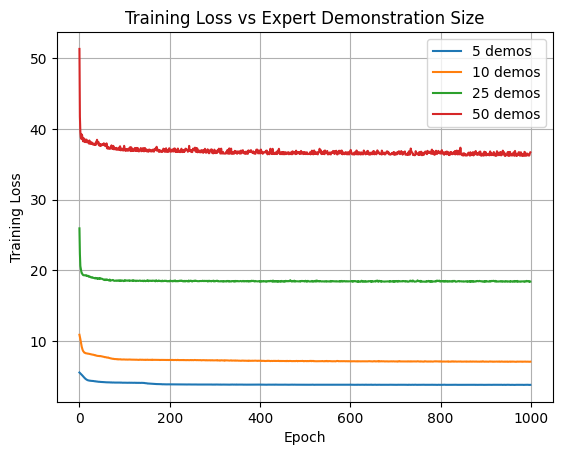

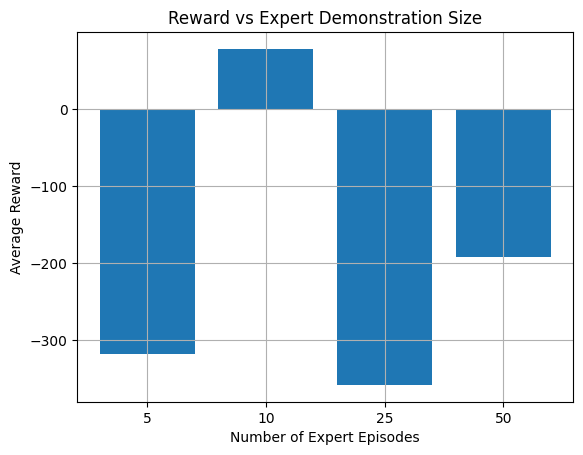

In [ ]:

# plot the loss graph
for n in demo_sizes:
    plt.plot(results[n]['losses'], label=f"{n} demos")
plt.xlabel("Epoch")
plt.ylabel("Training Loss")
plt.title("Training Loss vs Expert Demonstration Size")
plt.legend()
plt.grid(True)
plt.show()
print("\n")
# plot the rewards
plt.bar([str(n) for n in demo_sizes], [results[n]['avg_reward'] for n in demo_sizes])
plt.xlabel("Number of Expert Episodes")
plt.ylabel("Average Reward")
plt.title("Reward vs Expert Demonstration Size")
plt.grid(True)
plt.show()


### Results
1.  Training Loss based on demo Size
  - Models trained on smaller datasets (5 demos) had much lower training loss.

  - I think this is because they can easily memorize the small dataset (overfitting).

  - Models trained on larger datasets (25 or 50 demos) had higher loss, because they had to generalize more and couldn't memorize everything.

2. Average Reward based on Demo Size
  - Surprisingly, the model trained with 10 demos (default amount) performed the best.

  - 5 demos led to overfitting → low reward.

  - 25 and 50 demos gave even worse results.
  Possibly due to underfitting (model too simple for large data) Or the model needed more epochs or better architecture for complex data

---------------------------------------

# 3. Modify the expert policy to see its effect.

###  What I did

- I created a noisy expert using an epsilon-greedy strategy: With probability epsilon, take a random action. Otherwise, follow the expert policy

- I tested four levels of noise, [0.0, 0.1, 0.3, 0.5]

- For each epsilon, I collected expert demonstrations (25 episodes) and trained a behavior cloning model for 500 epochs

- I evaluated the model's performance using average reward over 5 episodes

- Finally, I plotted the average reward vs. epsilon level

In [ ]:
def noisy_expert_action(state, expert_policy, epsilon=0.2):
    if np.random.rand() < epsilon:
        return env.action_space.sample()  #it takes random action
    else:
        action, _ = expert_policy.predict(state)
        return action


In [ ]:
def generate_noisy_expert_data(env, expert_policy, num_episodes=10, epsilon=0.2):
    data = []
    for _ in range(num_episodes):
        state, _ = env.reset()
        done = False
        while not done:
            action = noisy_expert_action(state, expert_policy, epsilon)
            data.append((state, action))
            state, _, done, _, _ = env.step(action)
    return data


In [ ]:
epsilons = [0.0, 0.1, 0.3, 0.5]
rewards = []

for eps in epsilons:
    print(f"\n Training with noisy expert (epsilon={eps})")

    # collect data
    data = generate_noisy_expert_data(env, expert_policy, num_episodes=25, epsilon=eps)

    X = np.array([s for s, a in data])
    y = np.array([a for s, a in data])
    X_tensor = torch.FloatTensor(X).to('cuda')
    y_tensor = torch.LongTensor(y).to('cuda')

    # define the model and train the model woth epoch 500
    model = ImitationNetwork(input_dim, output_dim).to('cuda')
    optimizer = optim.Adam(model.parameters(), lr=1e-3)
    criterion = nn.CrossEntropyLoss()

    for epoch in range(500):
        indices = np.random.permutation(len(X))
        for i in range(0, len(X), 64):
            idx = indices[i:i+64]
            xb = X_tensor[idx]
            yb = y_tensor[idx]

            optimizer.zero_grad()
            out = model(xb)
            loss = criterion(out, yb)
            loss.backward()
            optimizer.step()

    # model evaluation
    reward = np.mean(evaluate(env, model.to('cpu'), num_episodes=5))
    rewards.append(reward)
    print(f"Avg reward with epsilon={eps}: {reward:.2f}")



 Training with noisy expert (epsilon=0.0)


 20%|██        | 1/5 [00:02<00:10,  2.70s/it]

Total reward: 261.4495512929766


 40%|████      | 2/5 [00:06<00:09,  3.19s/it]

Total reward: 288.4598575861264


 60%|██████    | 3/5 [00:09<00:06,  3.31s/it]

Total reward: 307.4609666049177


 80%|████████  | 4/5 [00:13<00:03,  3.34s/it]

Total reward: 265.70376660688873


100%|██████████| 5/5 [00:16<00:00,  3.34s/it]

Total reward: 300.93807637345265
Avg reward with epsilon=0.0: 284.80

 Training with noisy expert (epsilon=0.1)



 20%|██        | 1/5 [00:04<00:17,  4.37s/it]

Total reward: 285.47312758505507


 40%|████      | 2/5 [00:07<00:11,  3.86s/it]

Total reward: 288.37246384142185


 60%|██████    | 3/5 [00:11<00:07,  3.65s/it]

Total reward: 255.90946742396338


 80%|████████  | 4/5 [00:14<00:03,  3.65s/it]

Total reward: 268.83702835891097


100%|██████████| 5/5 [00:19<00:00,  3.83s/it]

Total reward: 284.0338509276425
Avg reward with epsilon=0.1: 276.53

 Training with noisy expert (epsilon=0.3)



 20%|██        | 1/5 [00:04<00:16,  4.19s/it]

Total reward: 248.62683390552766


 40%|████      | 2/5 [00:06<00:09,  3.24s/it]

Total reward: 69.58463867465818


 60%|██████    | 3/5 [00:09<00:06,  3.09s/it]

Total reward: 284.32738554316836


 80%|████████  | 4/5 [00:15<00:04,  4.19s/it]

Total reward: 263.33858727792324


100%|██████████| 5/5 [00:35<00:00,  7.14s/it]

Total reward: 17.117070061316856
Avg reward with epsilon=0.3: 176.60

 Training with noisy expert (epsilon=0.5)



 20%|██        | 1/5 [00:20<01:20, 20.15s/it]

Total reward: -17.014051523256455


 40%|████      | 2/5 [00:40<01:00, 20.16s/it]

Total reward: -1.719941089763162


 60%|██████    | 3/5 [01:00<00:40, 20.16s/it]

Total reward: -36.07862390562839


 80%|████████  | 4/5 [01:20<00:20, 20.15s/it]

Total reward: -45.92195834499344


100%|██████████| 5/5 [01:40<00:00, 20.15s/it]

Total reward: -18.537508428371535
Avg reward with epsilon=0.5: -23.85


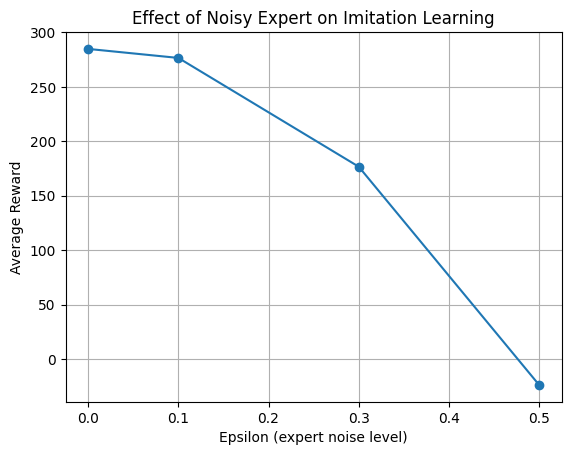

In [ ]:
plt.plot(epsilons, rewards, marker='o')
plt.xlabel("Epsilon (expert noise level)")
plt.ylabel("Average Reward")
plt.title("Effect of Noisy Expert on Imitation Learning")
plt.grid(True)
plt.show()


### Results
As you can see in the graph,

- When epsilon = 0.0 (no noise), the model learned well and achieved a high reward.

- Even with epsilon = 0.1, performance stayed almost the same — the model was still able to learn.

- At epsilon = 0.3, performance dropped clearly, meaning that the expert was less reliable.

- At epsilon = 0.5, performance collapsed. The reason is that the expert acted randomly half the time, and the model failed to imitate.

